In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

import pyfftw.interfaces.numpy_fft as fft
import pyfftw
import galsim

from scripts.BTK_generator import BTK_blend_generator as btk_generator
from scripts.BTK_generator import create_PSF_image as psf_img_gen
from scripts.FFT_calcs import FFT_IFFT_calc 
from scripts.FFT_calcs import create_deconv_img 

# 0. Goals

The goal of this notebook is to be able to tap into the different stages of the `isolated_images`. That is:
- `isolated_images` with PSF and noise $\leftarrow$ **Done**
- `isolated_images` with just PSF
- `isolated_images` with **NO** PSF **or** noise.

This is important because to do work with blending we need to know the PSF. So, what we want is:

1. A centered image of the PSF. This PSF is applied to the isolated galaxy images. $\leftarrow$ **Done**
    1. We want this because we are going to deconvolve the PSF from the galaxy image, so we need a noise-free image of the PSF.
    
2. The isolated galaxy images **BEFORE** the PSF is applied.
    1. With (1.) we take the FT of the galaxy images and the FT of the centered PSF and divide the FT galaxy by the FT of the PSF. Doing this in FS is equivalent to a deconvolution in the spatial domain. Once done, IFT back into the spatial domain and now you have the image of the isolated galaxy **before** application of PSF.
        2. NOTE: This is what the galaxy would look like from a space-based telescope.
        
3. The isolated galaxy images with PSF, but **no noise**.
    1. Just set the `add_noise` parameter in the blend generator to `None`. 
        2. NOTE: Pretty sure they are already noise free, but good to check.
    
    

# 1. Testing

## 1.1 Creating the centered PSF

In [2]:
blend_images, isolated_images, psf = btk_generator(catalog_name=None,
                                                  stamp_size=24.0,
                                                  max_number=1,
                                                  max_shift=0,
                                                  batch_size=10,
                                                  sampling_func=None,
                                                  survey="LSST",
                                                  add_noise="all")

Generating blends for LSST survey:   0%|          | 0/10 [00:00<?, ?it/s]

To print the attributes of an object use: `object.__dict__`. E.g. `PSF.__dict__`

To get the attributes of an object use `getattr`: E.g. `getattr(PSF, '_array')`

In [3]:
psf_imgs = psf_img_gen(psf_list=psf, blend_imgs=blend_images)

**Plot of the 6 LSST filter PSF images**

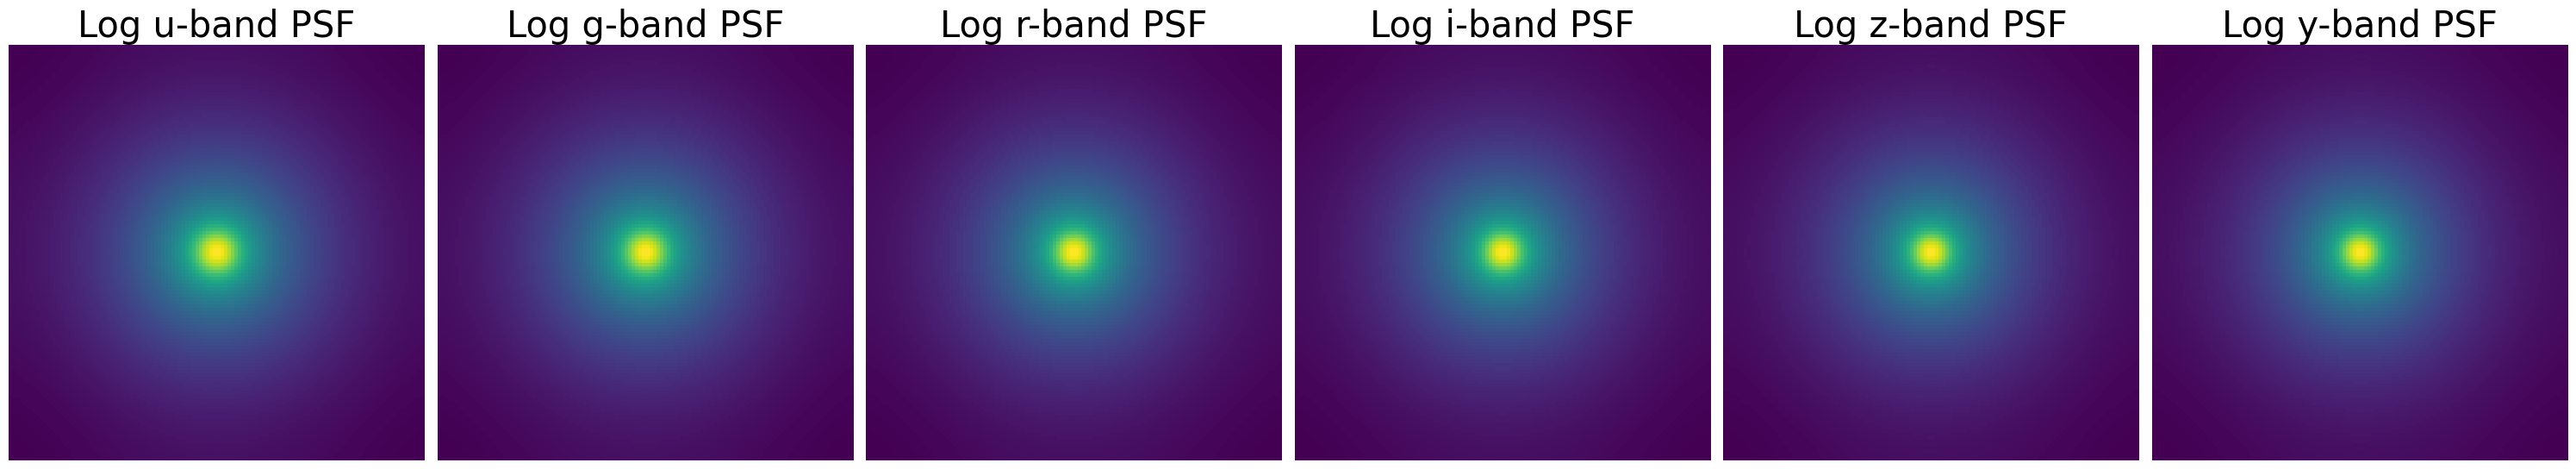

In [4]:
fig, axes = plt.subplots(1, 6, figsize=(30,26))
axes[0].imshow(np.log(psf_imgs[0]))
axes[0].axis('off')
axes[0].set_title('Log u-band PSF', fontsize=30)
axes[1].imshow(np.log(psf_imgs[1]))
axes[1].axis('off')
axes[1].set_title('Log g-band PSF', fontsize=30)
axes[2].imshow(np.log(psf_imgs[2]))
axes[2].axis('off')
axes[2].set_title('Log r-band PSF', fontsize=30)
axes[3].imshow(np.log(psf_imgs[3]))
axes[3].axis('off')
axes[3].set_title('Log i-band PSF', fontsize=30)
axes[4].imshow(np.log(psf_imgs[4]))
axes[4].axis('off')
axes[4].set_title('Log z-band PSF', fontsize=30)
axes[5].imshow(np.log(psf_imgs[5]))
axes[5].axis('off')
axes[5].set_title('Log y-band PSF', fontsize=30)

plt.tight_layout()
plt.show()

## 1.2 Creating the deconvolved galaxy images

These cells are meant to get the galaxy images as if theye were observed from space (ie. no PSF). To accomplish this we must FT both the PSF image, as well as, the galaxy image. Once in FS, a deconvolution is a simple division, which we compute and then IFT back into the spatial domain. This description is shown mathematically below:

$$ F^{-1}\big( \frac{\psi_{i}}{p_{k}} \big),$$

where:
- $\psi_i$ is the FT of the galaxy
- $p_{k}$ is the FT of the PSF
- $\frac{\psi_{i}}{p_{k}}$ is the deconvolution in FS
- $F^{-1}$ is the IFT of the deconvolved galaxy image.

We start with creating the galaxy and PSF images.

In [5]:
# Generate blends
blend_images, isolated_images, psf = btk_generator(catalog_name=None,
                                                  stamp_size=24.0,
                                                  max_number=3,
                                                  max_shift=0,
                                                  batch_size=10,
                                                  sampling_func=None,
                                                  survey="LSST",
                                                  add_noise="none")
# Generate PSF iamges from the blend generation info
psf_images = psf_img_gen(psf_list=psf,
                       blend_imgs=blend_images)

Generating blends for LSST survey:   0%|          | 0/10 [00:00<?, ?it/s]

**Plots of FT/IFT of galaxy images:**

In [6]:
def visualize_FT_pipeline(img):
    """
    Visualize the process of:
        Image -> FT(Image) -> IFT(FT(Image)) == Image
        
    Visual test that I'm implementing the FT/IFT correctly.
    
    Args:
    -----
        img: np.ndarray
            2D image array
    
    Returns:
    --------
        plt.plot of the input image, FT of input image, IFT of the
        FT'd input image.
    """
    f, fshift, magnitude = FFT_IFFT_calc(img)
    ift_img = FFT_IFFT_calc(fshift, FFT=False)
    
    
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(30,26))
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('Input Image', fontsize=30)
    axes[1].imshow(magnitude)
    axes[1].axis('off')
    axes[1].set_title('FT of Input', fontsize=30)
    axes[2].imshow(ift_img)
    axes[2].axis('off')
    axes[2].set_title("IFT of FT'd input", fontsize=30)
    print('Does the input image match the IFT output =', np.allclose(img, ift_img))

Does the input image match the IFT output = True


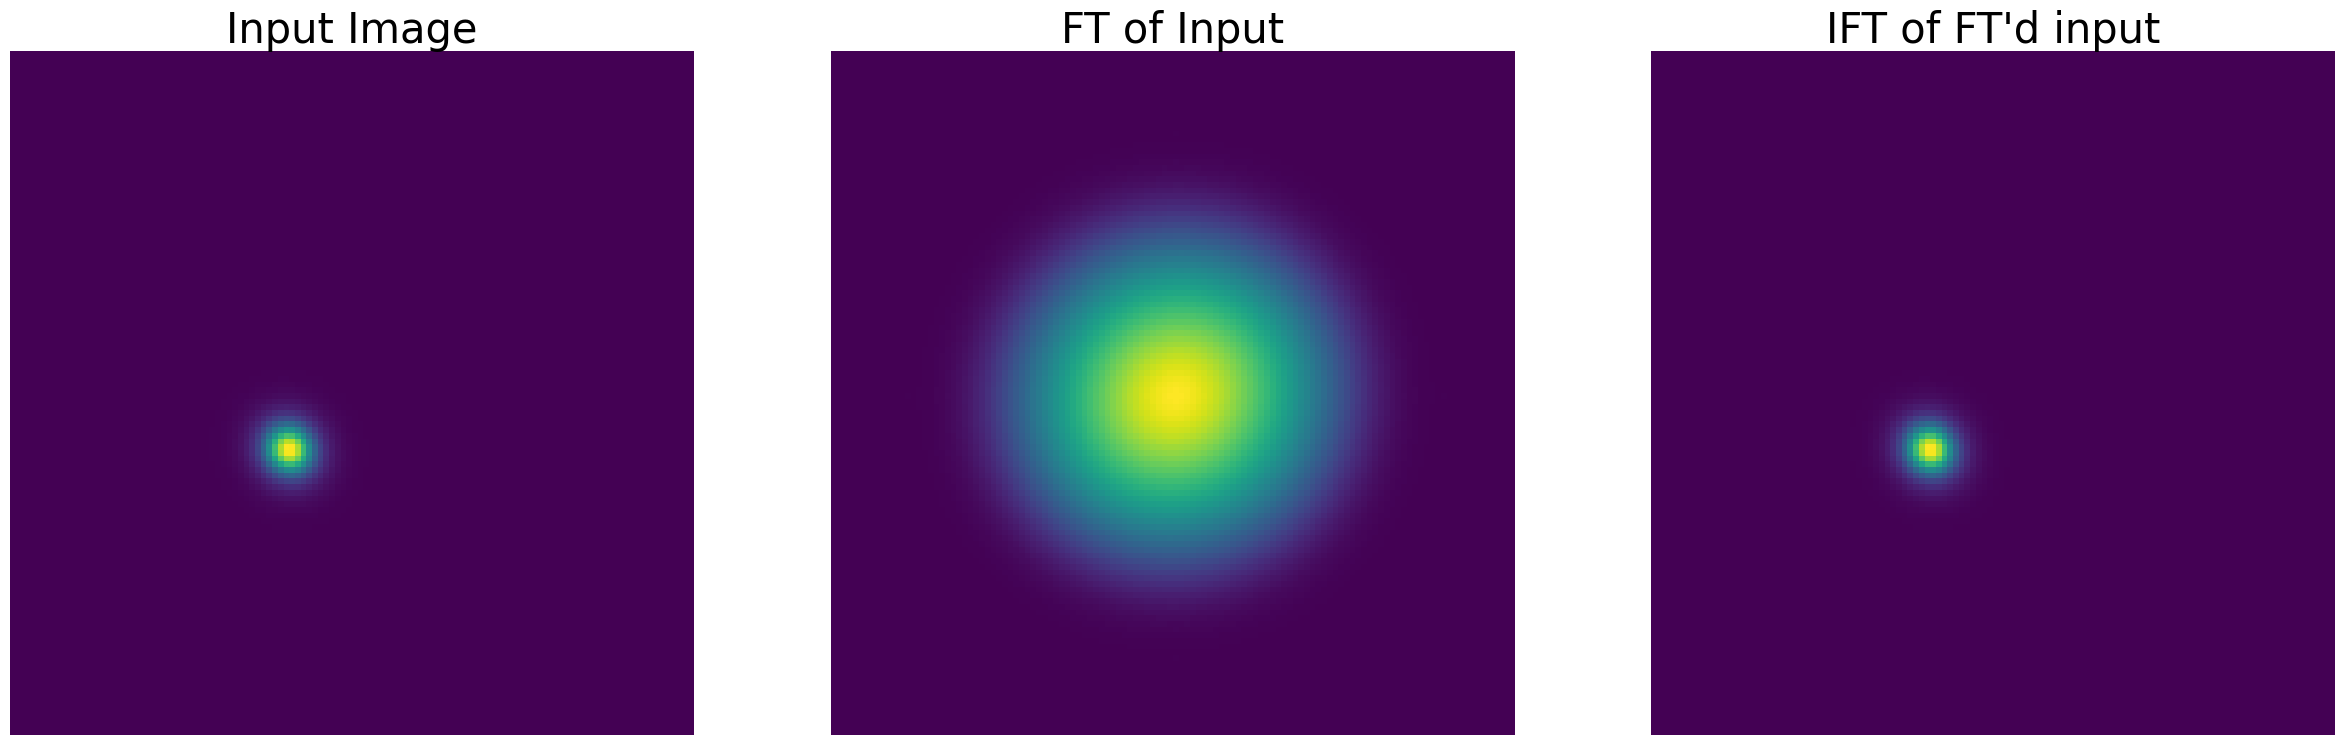

In [7]:
# Processing the data to be in the correct format for pyfftw
gal = isolated_images[0][0][0]
H_gal, W_gal = gal.shape
gal_arr = pyfftw.empty_aligned((H_gal, W_gal), dtype=np.float64)
gal_arr[:, :] = gal

visualize_FT_pipeline(gal)

**Plots of FT/IFT of PSF images:**

Does the input image match the IFT output = True


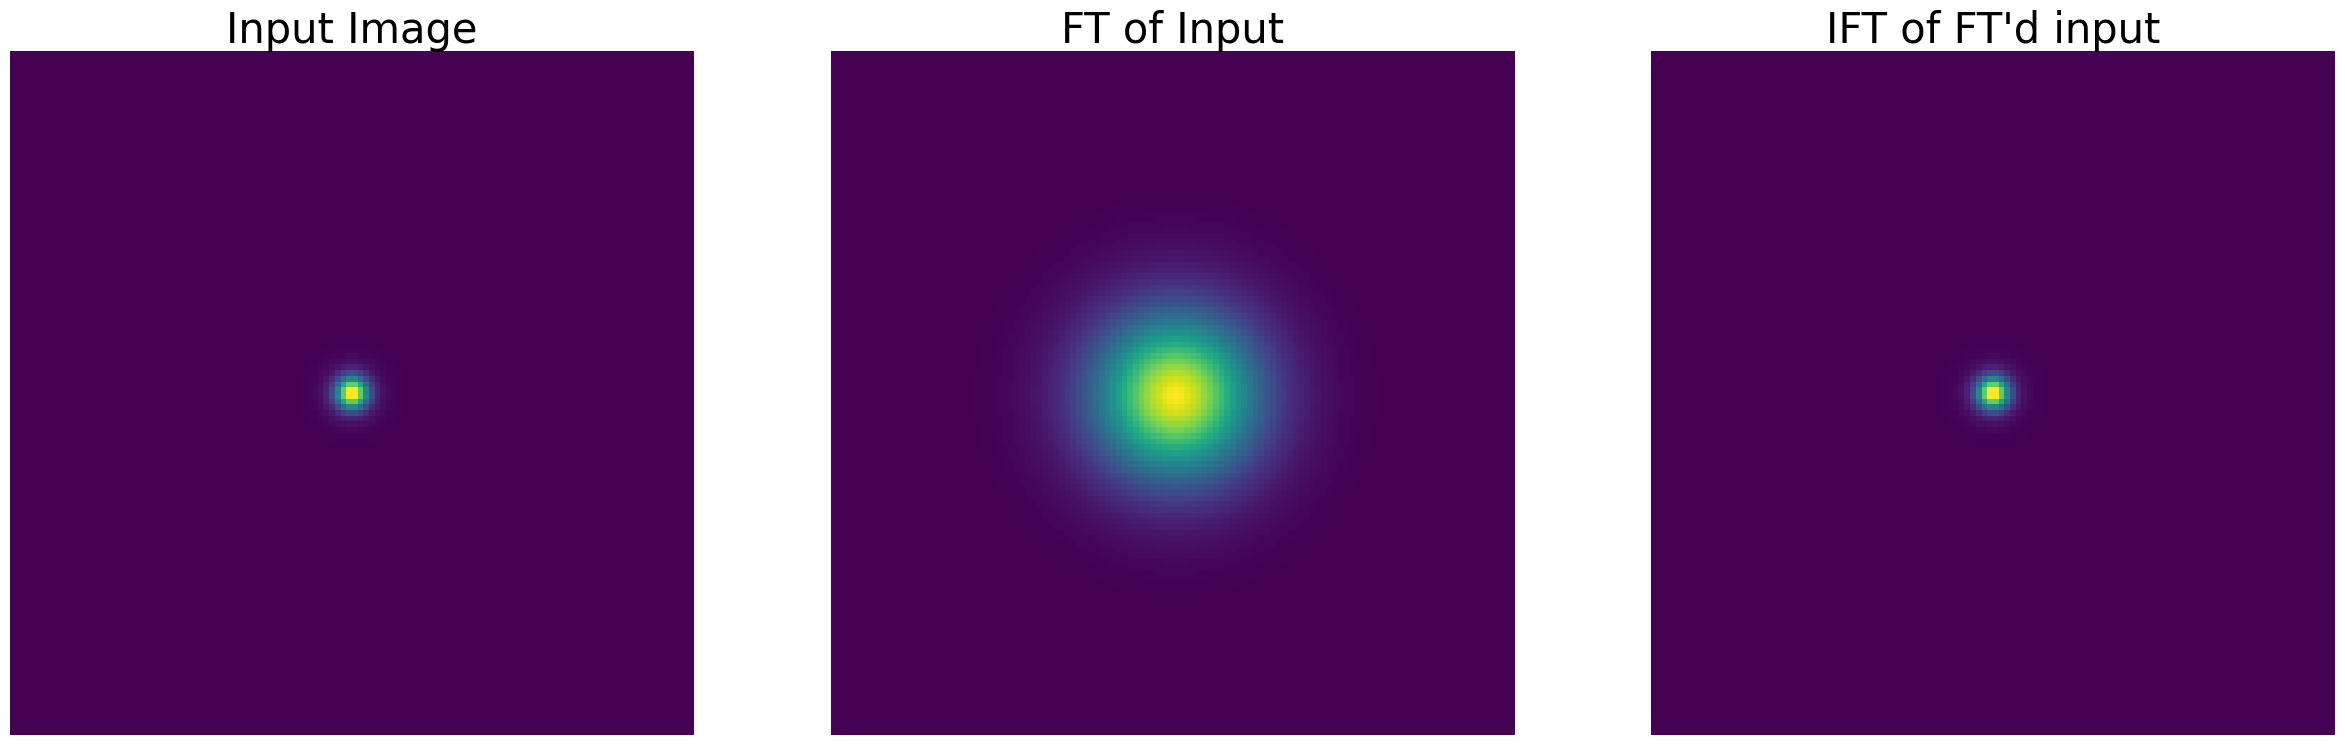

In [8]:
psf_img = psf_images[0]
H_psf, W_psf = psf_img.shape
psf = pyfftw.empty_aligned((H_psf, W_psf), dtype=np.float64)
psf[:, :] = psf_img

visualize_FT_pipeline(psf)

**Plots of the Deconvolved Galaxy Image**

**Doing some testing on the PSF. I think the problem is that the PSF's FT is close to 0, so we are getting dividing by zero errors. Going to replace the zero/near-zero values with some constant value.** Watched this [video](https://www.youtube.com/watch?v=6gweWmvLa-8) to help figure out what was wrong with the code. [Videos Github](https://github.com/maponti/imageprocessing_course_icmc/blob/master/05b_restoration_deconvolution.ipynb).

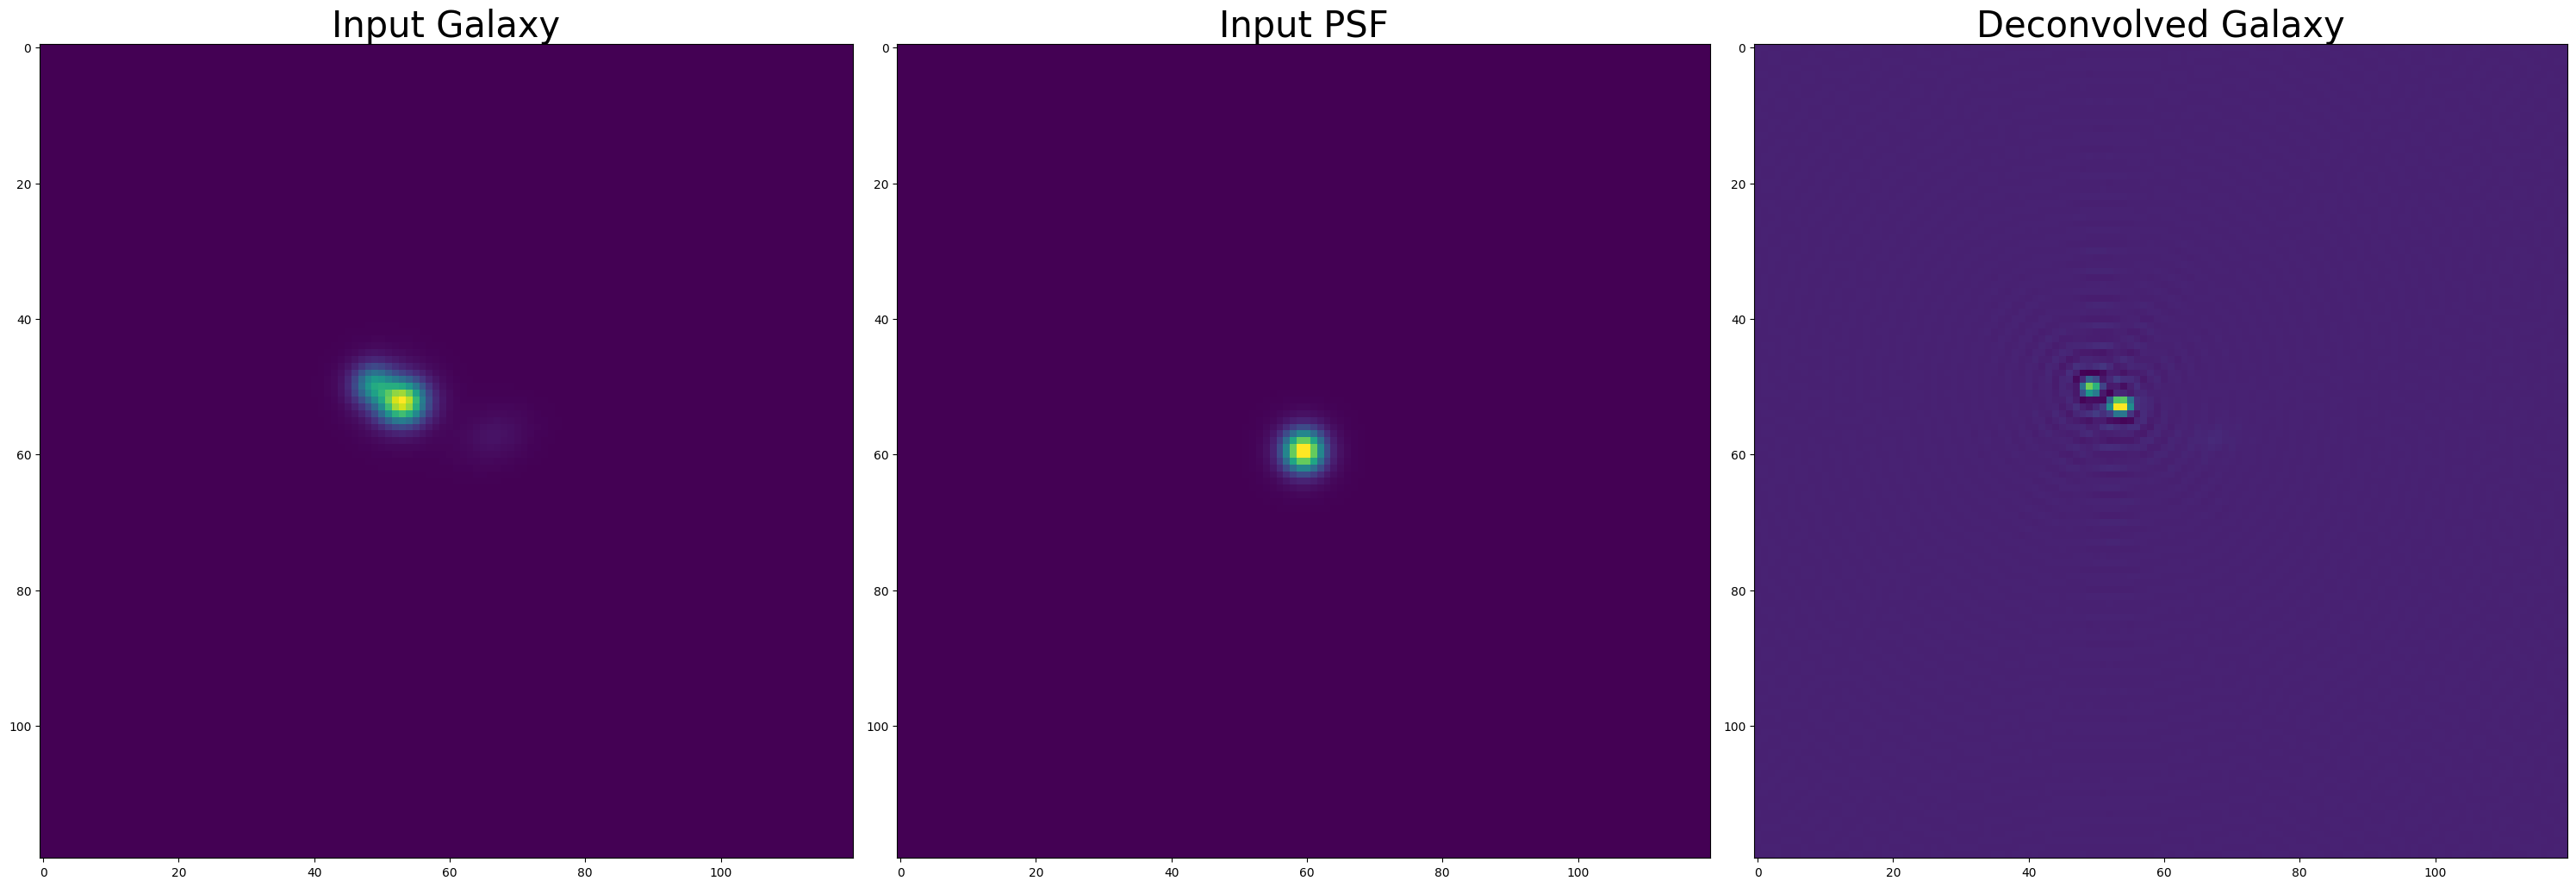

In [9]:
deconv_img, gal, psf_img = create_deconv_img(img=blend_images,
                                           psf=psf_images,
                                           sample_idx=9,
                                           gal_num_idx=0,
                                           filter_idx=0,
                                           eps=0.02)

fig, axes = plt.subplots(1, 3, figsize=(30,26))
axes[0].imshow(gal)
axes[0].axis('on')
axes[0].set_title('Input Galaxy', fontsize=30)
axes[1].imshow(psf_img)
axes[1].axis('on')
axes[1].set_title('Input PSF', fontsize=30)
axes[2].imshow(deconv_img)
axes[2].axis('on')
axes[2].set_title('Deconvolved Galaxy', fontsize=30)

fig.tight_layout()
plt.show()

## Trying to understand ringing

These tests are to show how noticeable the ringing is in the deconvolved image. This ringing contributes negative values, so that when viewing the residual images we are seeing noticeable peaks and troughs between positive and negative pixel values

**Horizontal**

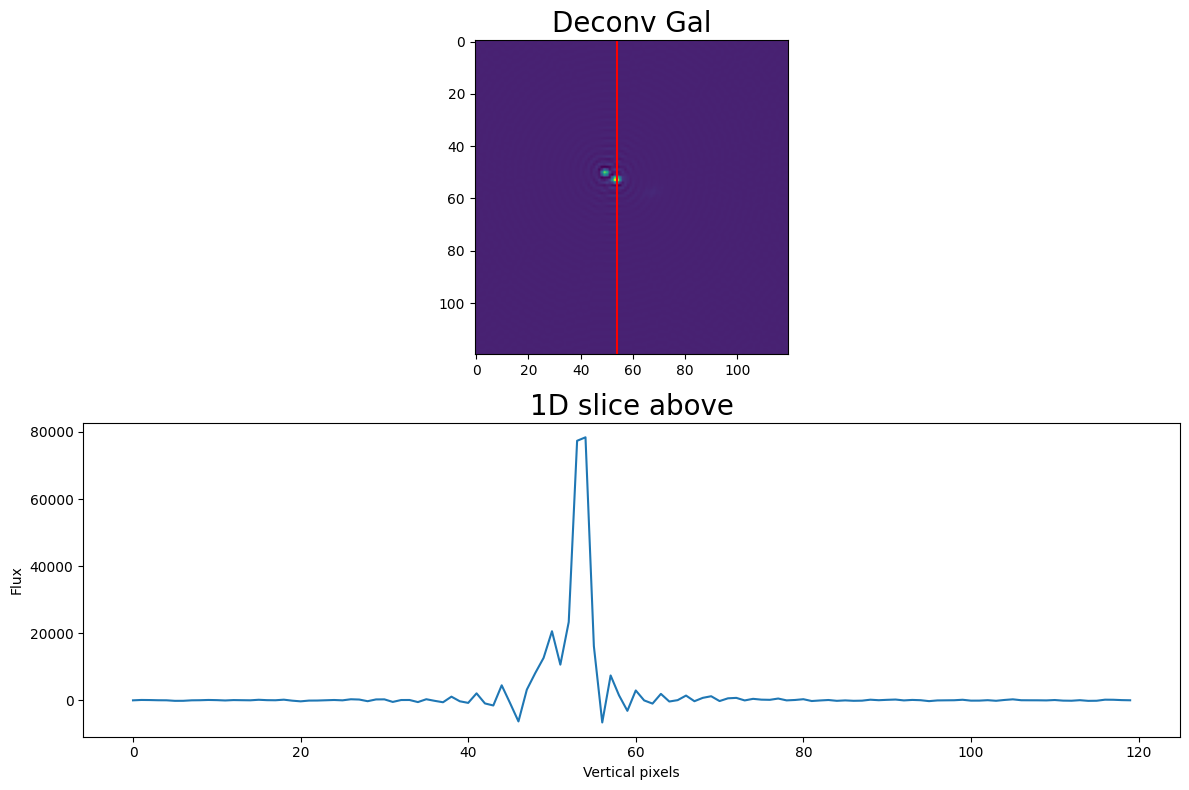

In [10]:
x_idx = 54
y = deconv_img[x_idx,:]

fig, axes = plt.subplots(2, 1, figsize=(12,8))
axes[0].imshow(deconv_img)
axes[0].plot([x_idx, x_idx], [0,119], 'r-')
axes[0].axis('on')
axes[0].set_title('Deconv Gal', fontsize=20)
axes[1].plot(np.arange(len(y)), y)
axes[1].axis('on')
axes[1].set_ylabel('Flux')
axes[1].set_xlabel('Vertical pixels')
axes[1].set_title('1D slice above', fontsize=20)

fig.tight_layout()
plt.show()

**Horizontal**

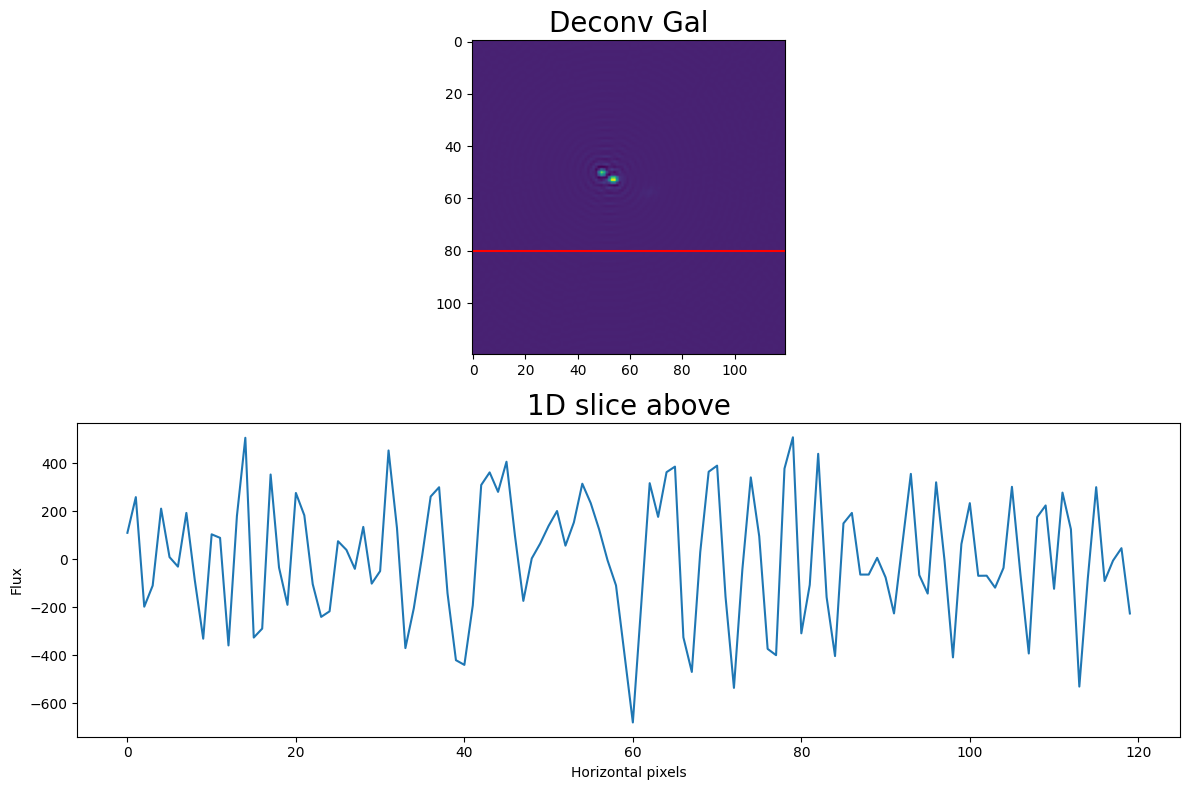

In [11]:
y_idx = 80
y = deconv_img[:,y_idx]

fig, axes = plt.subplots(2, 1, figsize=(12,8))
axes[0].imshow(deconv_img)
axes[0].plot([0, 119], [y_idx,y_idx], 'r-')
axes[0].axis('on')
axes[0].set_title('Deconv Gal', fontsize=20)
axes[1].plot(np.arange(len(y)), y)
axes[1].set_ylabel('Flux')
axes[1].set_xlabel('Horizontal pixels')
axes[1].axis('on')
axes[1].set_title('1D slice above', fontsize=20)

fig.tight_layout()
plt.show()

## Testing renormalization of PSF

In [12]:
def create_deconv_img_old(img, psf, 
                      sample_idx=0, gal_num_idx=0, filter_idx=0,
                      eps=0.0002):
    """
    Function that deconvolved galaxy image with its PSF image.
    The deconvolution calculation uses the convolution theorem, 
    which states that a deconvolution in Fourier Space is just
    the division of the FT of the image and the FT of the PSF ie:

    Deconvolved image = IFT(FT(img) / FT(psf_img))

    Args:
    -----
        img: np.ndarray
            An array of either a blended galaxy scene or an 
            isolated galaxy scene.
            NOTE: The number of galaxys in the blended scene
                  determines the number of isolated galaxy 
                  scenes. 
                  E.g. 3 galaxy blend = 3 individual isolated
                                        galaxy images
        psf: np.ndarray
            An array of the PSF image in a specific LSST band.
            Shape: (H, W)
        sample_idx: int
            The index of the sample that we want to deconvolve.
            Defaults to 0.
        gal_num_idx: int
            The index of which galaxy isolated galaxy image from
            the blended scene to use for deconvolution.
        filter_idx: int
            The specific LSST filter galaxy image to use. 
            There are 6 LSST filters. They correspond to:
                - u: 0
                - g: 1
                - r: 2
                - i: 3
                - z: 4
                - y: 5
        eps: float
            The constant value that replaces zero (or near-zero
            values) in the Fourier Transformed PSF image.

    Returns:
    --------
        deconv_img = np.ndarray
            An array containing the deconvolved galaxy image.
            Shape: (H, W)
    """
    
    # Isolated Images
    if img.ndim == 5:
    
        # Test to see how this does when we replace zero/near-zero FT PSF values to a constant value
        gal = img[sample_idx][gal_num_idx][filter_idx]
        psf_img = psf[filter_idx]

        GAL = fft.fft2(gal)
        PSF = fft.fft2(psf_img)
        # Changing values close to 0 to eps to allow for deconvolution division
        PSF[np.abs(PSF) <= 0.0002]  = eps

        # Deconvolution/ inverse filtering
        deconv_hat = np.divide(GAL, PSF)

        deconv_img = fft.ifft2(deconv_hat).real
        deconv_img = fft.ifftshift(deconv_img)
    
        return deconv_img, gal, psf_img
    
    # Blended Images
    else:
        # Test to see how this does when we replace zero/near-zero FT PSF values to a constant value
        gal = img[sample_idx][filter_idx]
        psf_img = psf[filter_idx]

        GAL = fft.fft2(gal)
        PSF = fft.fft2(psf_img)
        # Changing values close to 0 to eps to allow for deconvolution division
        PSF[np.abs(PSF) <= 0.0002]  = eps

        # Deconvolution/ inverse filtering
        deconv_hat = np.divide(GAL, PSF)

        deconv_img = fft.ifft2(deconv_hat).real
        deconv_img = fft.ifftshift(deconv_img)
    
        return deconv_img, gal, psf_img
    
    
def vis_ringing(img, y_idx=50, x_idx=50):
    """
    Basic function to visualize two 1D slices of the deconvolved image
    to see how the flux changes along a specified slice. This is to help
    visualize the ringing in the image (ie. changing of positive and negative)
    fluxs.
    
    Args:
    -----
        img: np.ndarray
            2D image array
        y_idx: int
            The y-index for the horizontal slice to be taken at
            Defaults to 50.
        y_idx: int
            The x-index for the vretical slice to be taken at.
            Defaults to 50.
    
    Output:
    -------
        Input image with the overlaid slices to aid the viewer in understanding
        where the flux plots are coming from.
    
    """

    size = len(img)
    x = img[:, y_idx]
    y = img[x_idx, :]
    
    fig, axes = plt.subplots(3, 1, figsize=(20,16))
    axes[0].imshow(deconv_img)
    axes[0].plot([0, size-1], [y_idx,y_idx], 'r-')
    axes[0].plot([x_idx,x_idx], [0, size-1], 'y-')
    axes[0].axis('on')
    axes[0].set_title('Deconv Gal', fontsize=20)
    
    axes[1].plot(np.arange(size), x)
    axes[1].set_ylabel('Flux')
    axes[1].set_xlabel('Horizontal pixels')
    axes[1].axis('on')
    axes[1].set_title('Red slice flux', fontsize=20)
    
    axes[2].plot(np.arange(size), y)
    axes[2].set_ylabel('Flux')
    axes[2].set_xlabel('Vertical pixels')
    axes[2].axis('on')
    axes[2].set_title('Yellow slice flux', fontsize=20)

    fig.tight_layout()
    plt.show()

Sum of New Deconv image = 1077103.384680074
Sum of Old Deconv image = 6448.880498074848
167.02176214951047


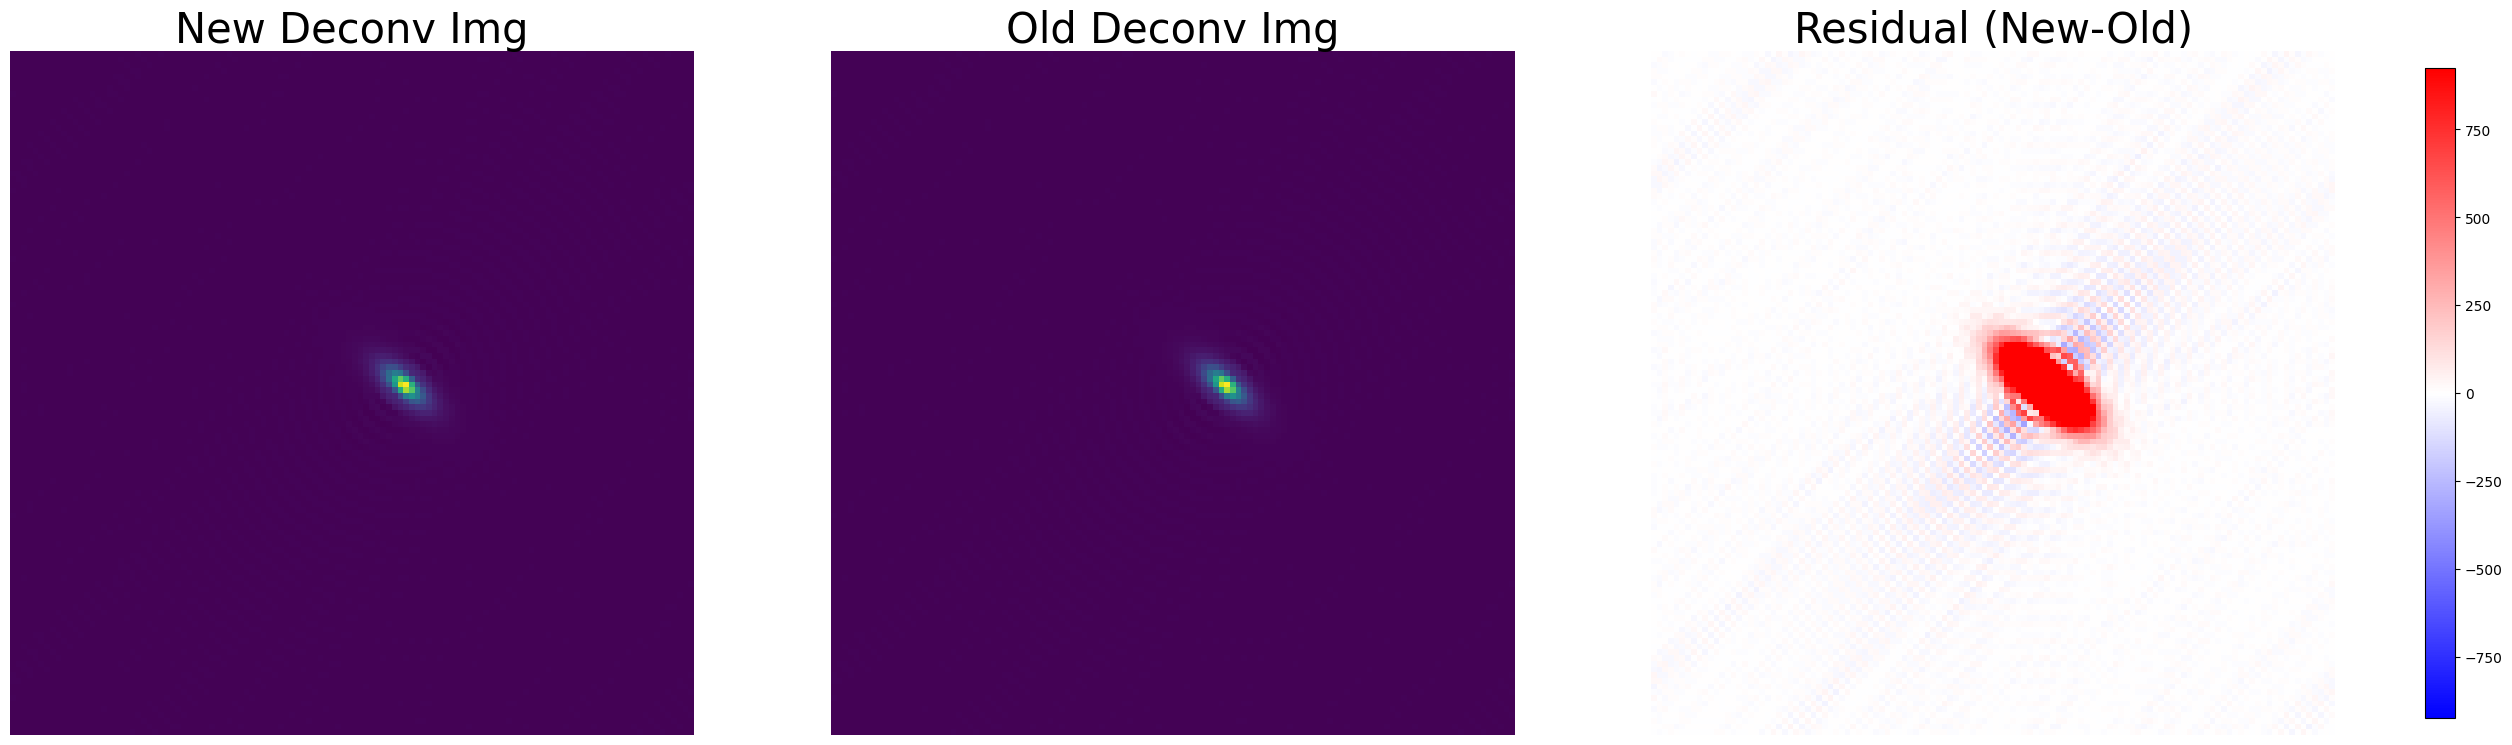

In [13]:
deconv_img, gal, psf_img = create_deconv_img(img=isolated_images,
                                           psf=psf_images,
                                           sample_idx=2,
                                           gal_num_idx=0,
                                           filter_idx=0,
                                           eps=0.02)

deconv_img_old, gal, psf_img = create_deconv_img_old(img=isolated_images,
                                           psf=psf_images,
                                           sample_idx=2,
                                           gal_num_idx=0,
                                           filter_idx=0,
                                           eps=0.02)

resid_deconv = deconv_img - deconv_img_old
vmax = np.percentile((resid_deconv), (99))
vmin = -vmax

fig, axes = plt.subplots(1, 3, figsize=(30,26), sharex=True, sharey=True)
axes[0].imshow(deconv_img)
axes[0].axis('off')
axes[0].set_title('New Deconv Img', fontsize=30)
axes[1].imshow(deconv_img_old)
axes[1].axis('off')
axes[1].set_title('Old Deconv Img', fontsize=30)
im = axes[2].imshow(resid_deconv,vmin=vmin, vmax=vmax, cmap='bwr')
axes[2].axis('off')
axes[2].set_title('Residual (New-Old)', fontsize=30)

cax = plt.axes([0.93, 0.37, 0.01, 0.25])
fig.colorbar(im, cax=cax, ax=axes[2])
print("Sum of New Deconv image =", np.sum(deconv_img))
print("Sum of Old Deconv image =", np.sum(deconv_img_old))
print(np.sum(deconv_img)/np.sum(deconv_img_old))

plt.show()

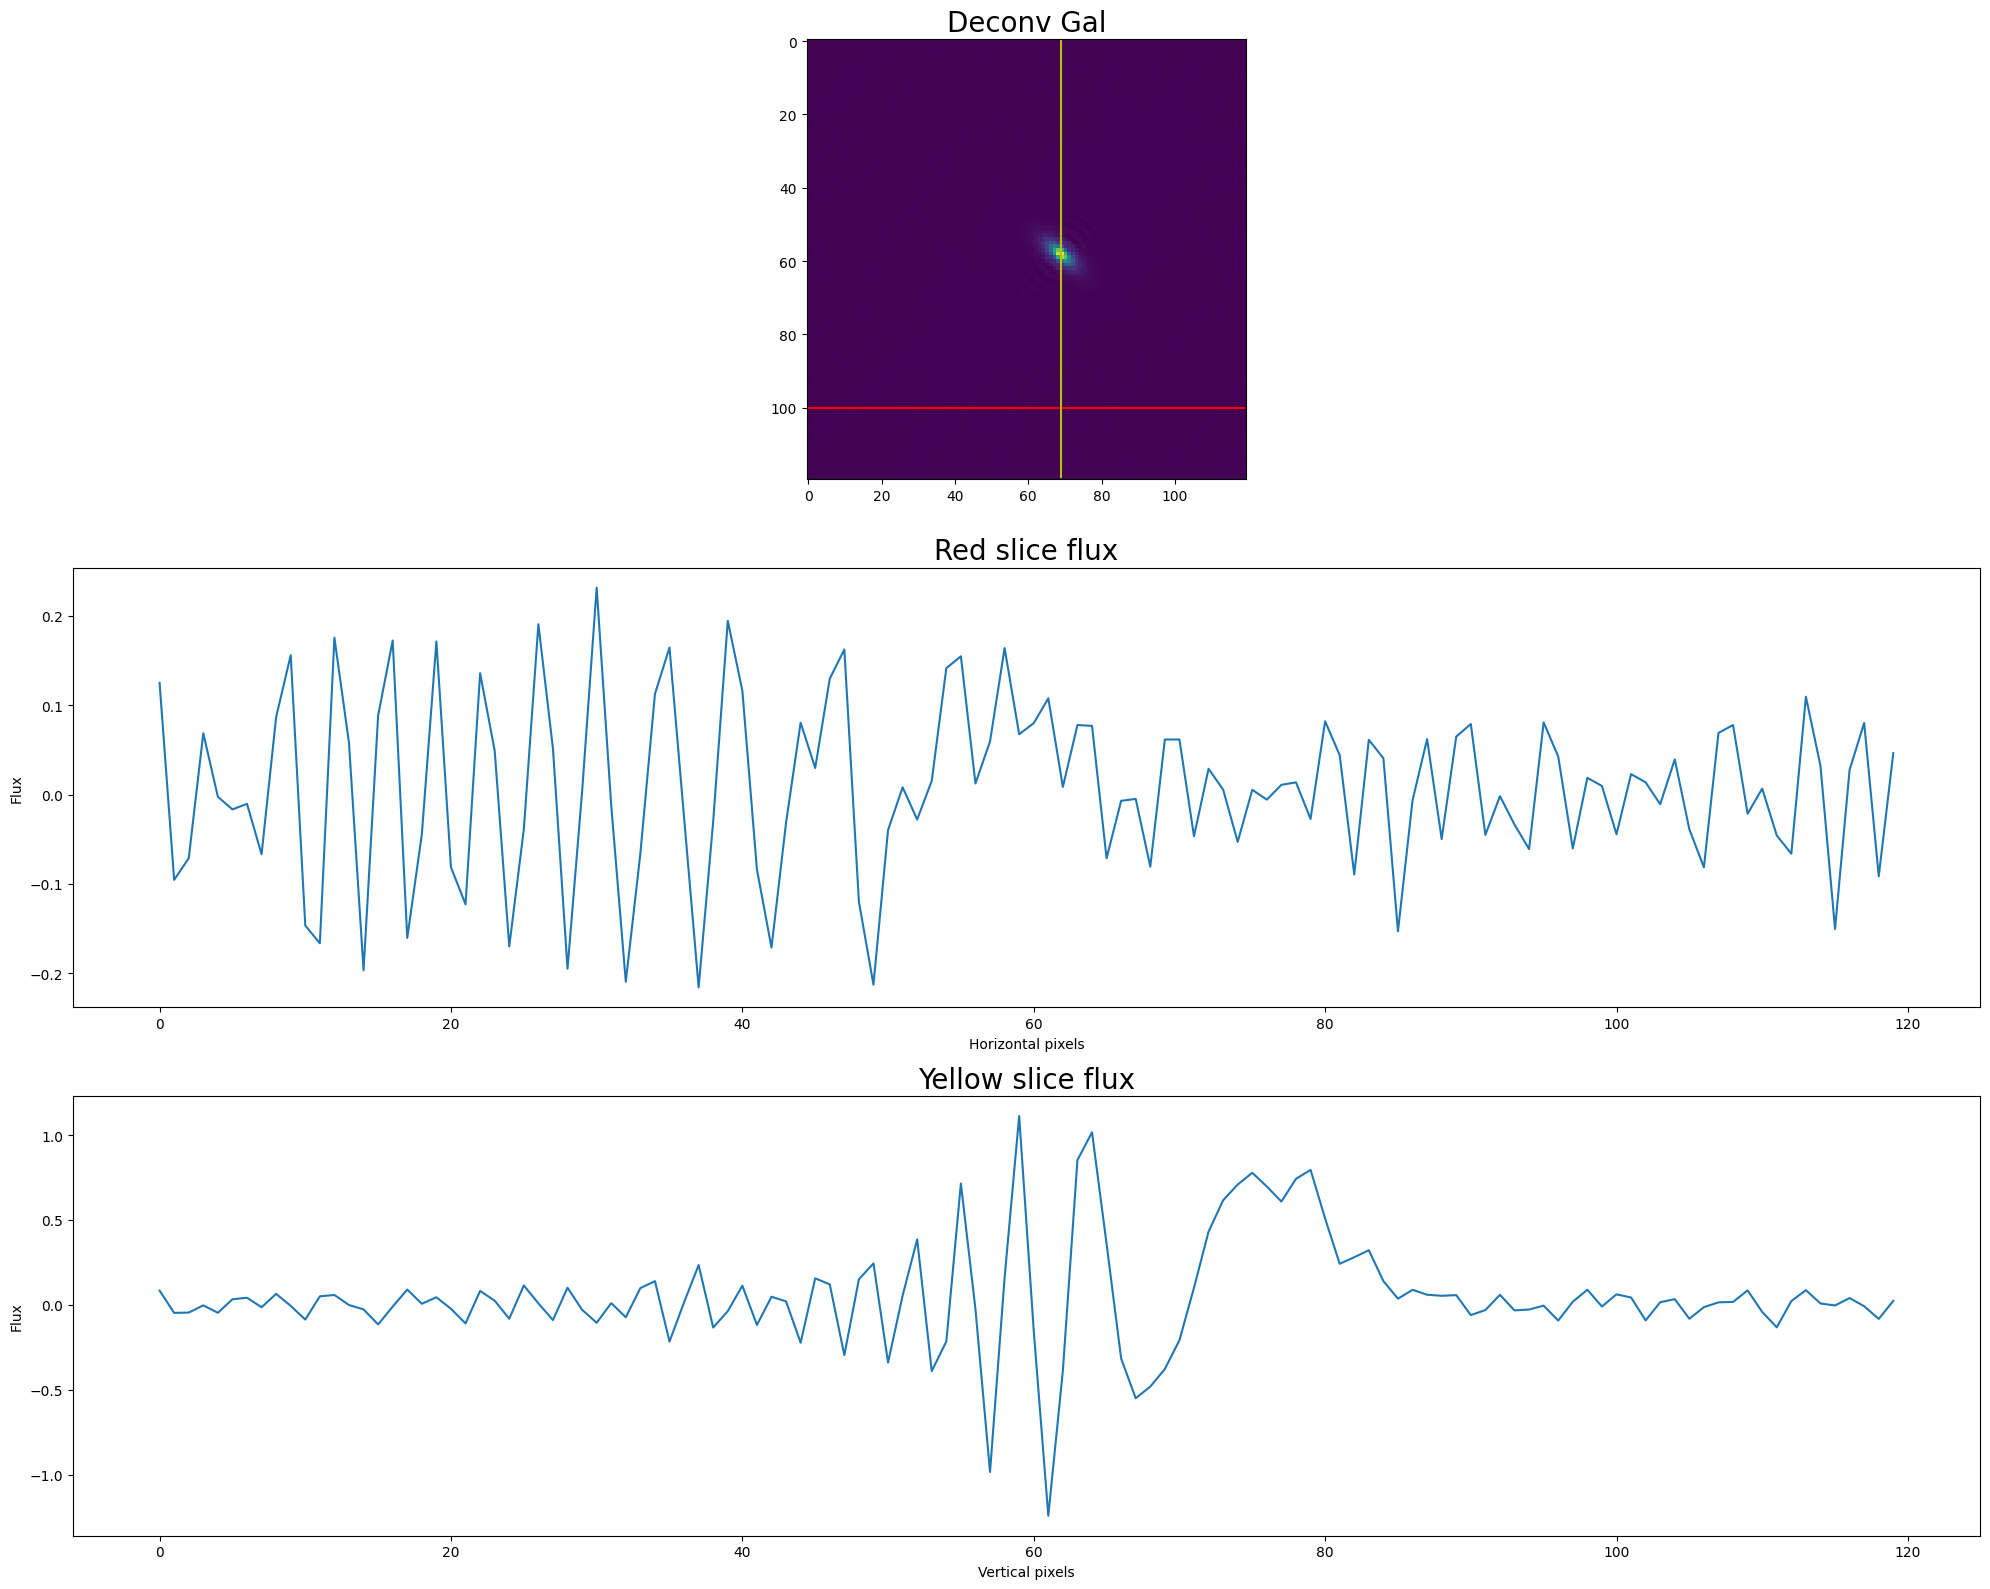

In [14]:
vis_ringing(img=deconv_img_old, x_idx=69, y_idx=100)

In [15]:
ind_max = np.unravel_index(np.argmax(deconv_img, axis=None), deconv_img.shape)
ind_min = np.unravel_index(np.argmin(deconv_img, axis=None), deconv_img.shape)

print("New max =", deconv_img[ind_max])
print("New min =", deconv_img[ind_min])
print("New max ind =", ind_max)
print("New min ind =", ind_min)

ind_max_old = np.unravel_index(np.argmax(deconv_img_old, axis=None), deconv_img_old.shape)
ind_min_old = np.unravel_index(np.argmin(deconv_img_old, axis=None), deconv_img_old.shape)

print("Old max =", deconv_img_old[ind_max_old])
print("Old min =", deconv_img_old[ind_min_old])
print("Old max ind =", ind_max_old)
print("Old min ind =", ind_min_old)

New max = 45584.64389693297
New min = -340.6565160120173
New max ind = (58, 69)
New min ind = (65, 65)
Old max = 272.9263731016327
Old min = -2.0395934923068544
Old max ind = (58, 69)
Old min ind = (65, 65)


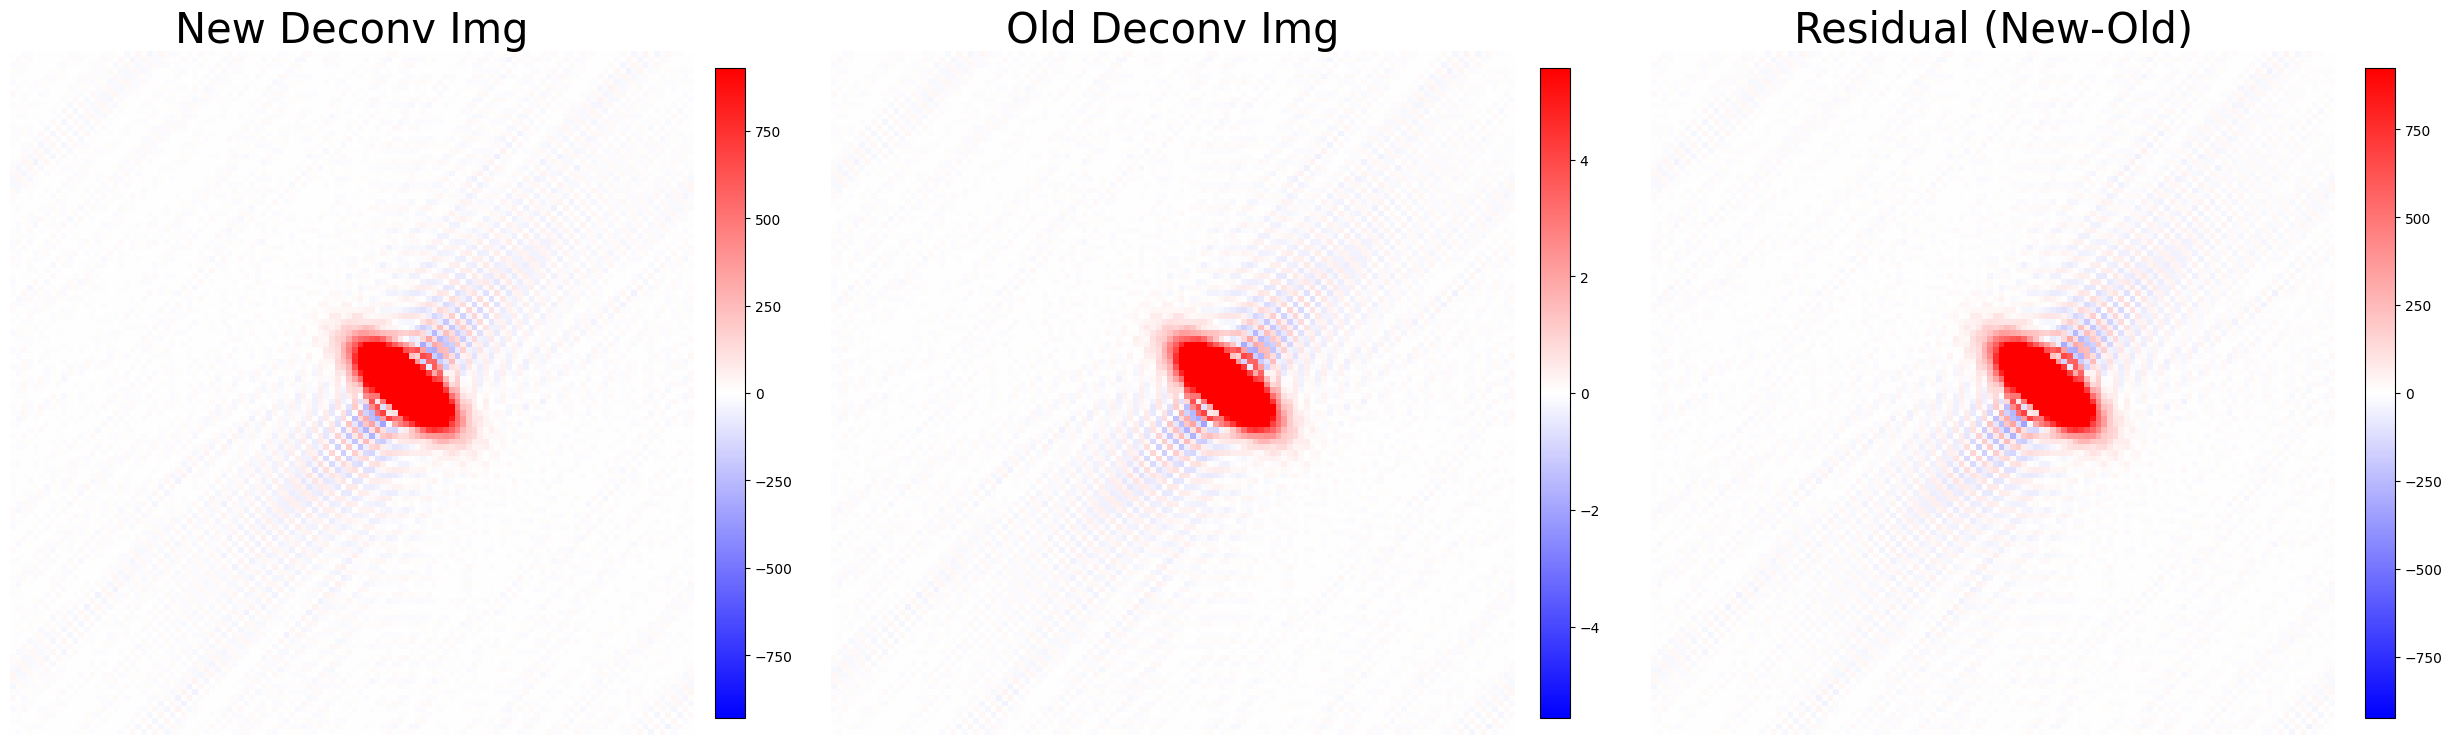

In [16]:
deconv_img, gal, psf_img = create_deconv_img(img=isolated_images,
                                           psf=psf_images,
                                           sample_idx=2,
                                           gal_num_idx=0,
                                           filter_idx=0,
                                           eps=0.02)

deconv_img_old, gal, psf_img = create_deconv_img_old(img=isolated_images,
                                           psf=psf_images,
                                           sample_idx=2,
                                           gal_num_idx=0,
                                           filter_idx=0,
                                           eps=0.02)
resid_deconv = deconv_img - deconv_img_old



vmax0 = np.percentile((deconv_img), (99))
vmin0 = -vmax0

fig, axes = plt.subplots(1, 3, figsize=(30,26), sharex=True, sharey=True)
im0 = axes[0].imshow(deconv_img, vmin=vmin0, vmax=vmax0, cmap='bwr')
cax = plt.axes([0.36, 0.37, 0.01, 0.25])
fig.colorbar(im0, cax=cax, ax=axes[0])
axes[0].axis('off')
axes[0].set_title('New Deconv Img', fontsize=30)



vmax1 = np.percentile((deconv_img_old), (99))
vmin1 = -vmax1
im1 = axes[1].imshow(deconv_img_old, vmin=vmin1, vmax=vmax1, cmap='bwr')
cax = plt.axes([0.635, 0.37, 0.01, 0.25])
fig.colorbar(im1, cax=cax, ax=axes[1])
axes[1].axis('off')
axes[1].set_title('Old Deconv Img', fontsize=30)




vmax_resid = np.percentile((resid_deconv), (99))
vmin_resid = -vmax_resid

im2 = axes[2].imshow(resid_deconv,vmin=vmin_resid, vmax=vmax_resid, cmap='bwr')
axes[2].axis('off')
axes[2].set_title('Residual (New-Old)', fontsize=30)
cax = plt.axes([0.91, 0.37, 0.01, 0.25])
fig.colorbar(im2, cax=cax, ax=axes[2])

plt.show()

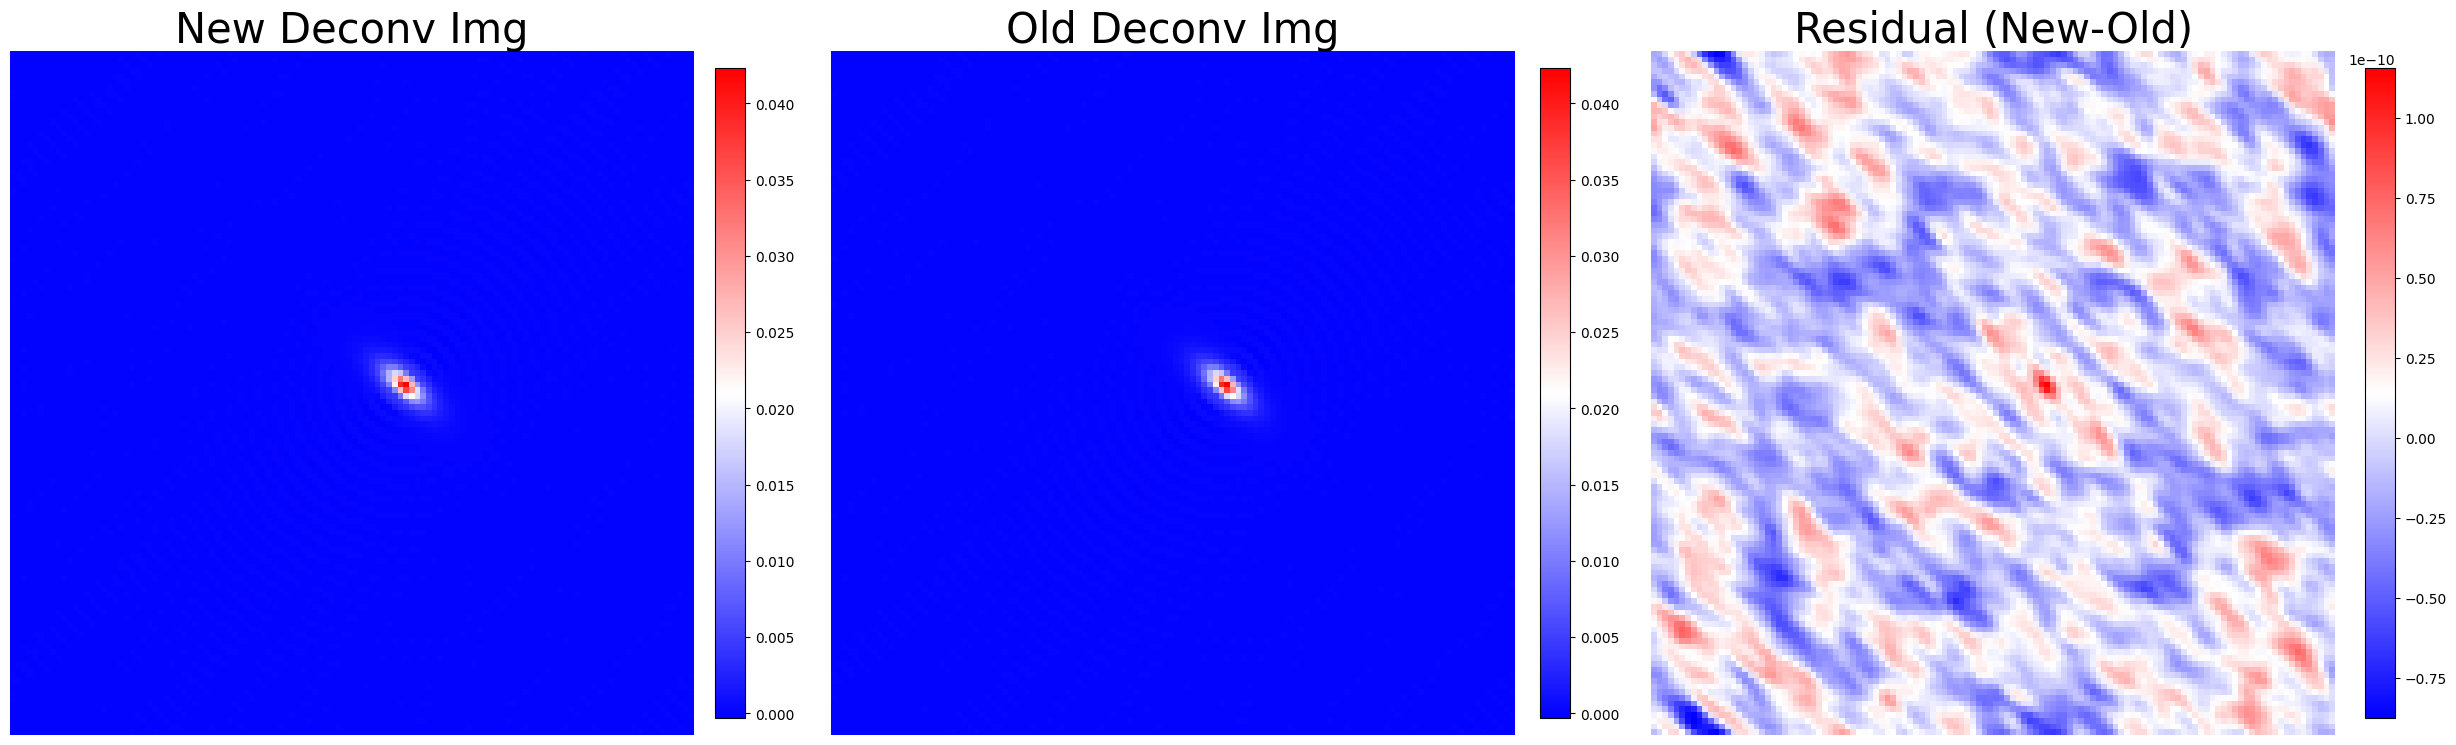

In [17]:
deconv_img, gal, psf_img = create_deconv_img(img=isolated_images,
                                           psf=psf_images,
                                           sample_idx=2,
                                           gal_num_idx=0,
                                           filter_idx=0,
                                           eps=0.02)

deconv_img_old, gal, psf_img = create_deconv_img_old(img=isolated_images,
                                           psf=psf_images,
                                           sample_idx=2,
                                           gal_num_idx=0,
                                           filter_idx=0,
                                           eps=0.02)

# Normalize the flux to be between [-1,1]
deconv_img = deconv_img/np.sum(deconv_img)
deconv_img_old = deconv_img_old/np.sum(deconv_img_old)

# Calculate residual of the two images
resid_deconv = (deconv_img) - (deconv_img_old)
vmax_resid = np.percentile((resid_deconv), (99))
vmin_resid = -vmax_resid


fig, axes = plt.subplots(1, 3, figsize=(30,26), sharex=True, sharey=True)
im0 = axes[0].imshow(deconv_img, cmap='bwr')
cax = plt.axes([0.36, 0.37, 0.01, 0.25])
fig.colorbar(im0, cax=cax, ax=axes[0])
axes[0].axis('off')
axes[0].set_title('New Deconv Img', fontsize=30)


im1 = axes[1].imshow(deconv_img_old, cmap='bwr')
cax = plt.axes([0.635, 0.37, 0.01, 0.25])
fig.colorbar(im1, cax=cax, ax=axes[1])
axes[1].axis('off')
axes[1].set_title('Old Deconv Img', fontsize=30)

im2 = axes[2].imshow(resid_deconv, cmap='bwr')
axes[2].axis('off')
axes[2].set_title('Residual (New-Old)', fontsize=30)
cax = plt.axes([0.91, 0.37, 0.01, 0.25])
fig.colorbar(im2, cax=cax, ax=axes[2])

plt.show()

**Two galaxies**

Sum of New Deconv image = 2173564.3662227127
Sum of Old Deconv image = 13013.659646801203
167.02176214951044


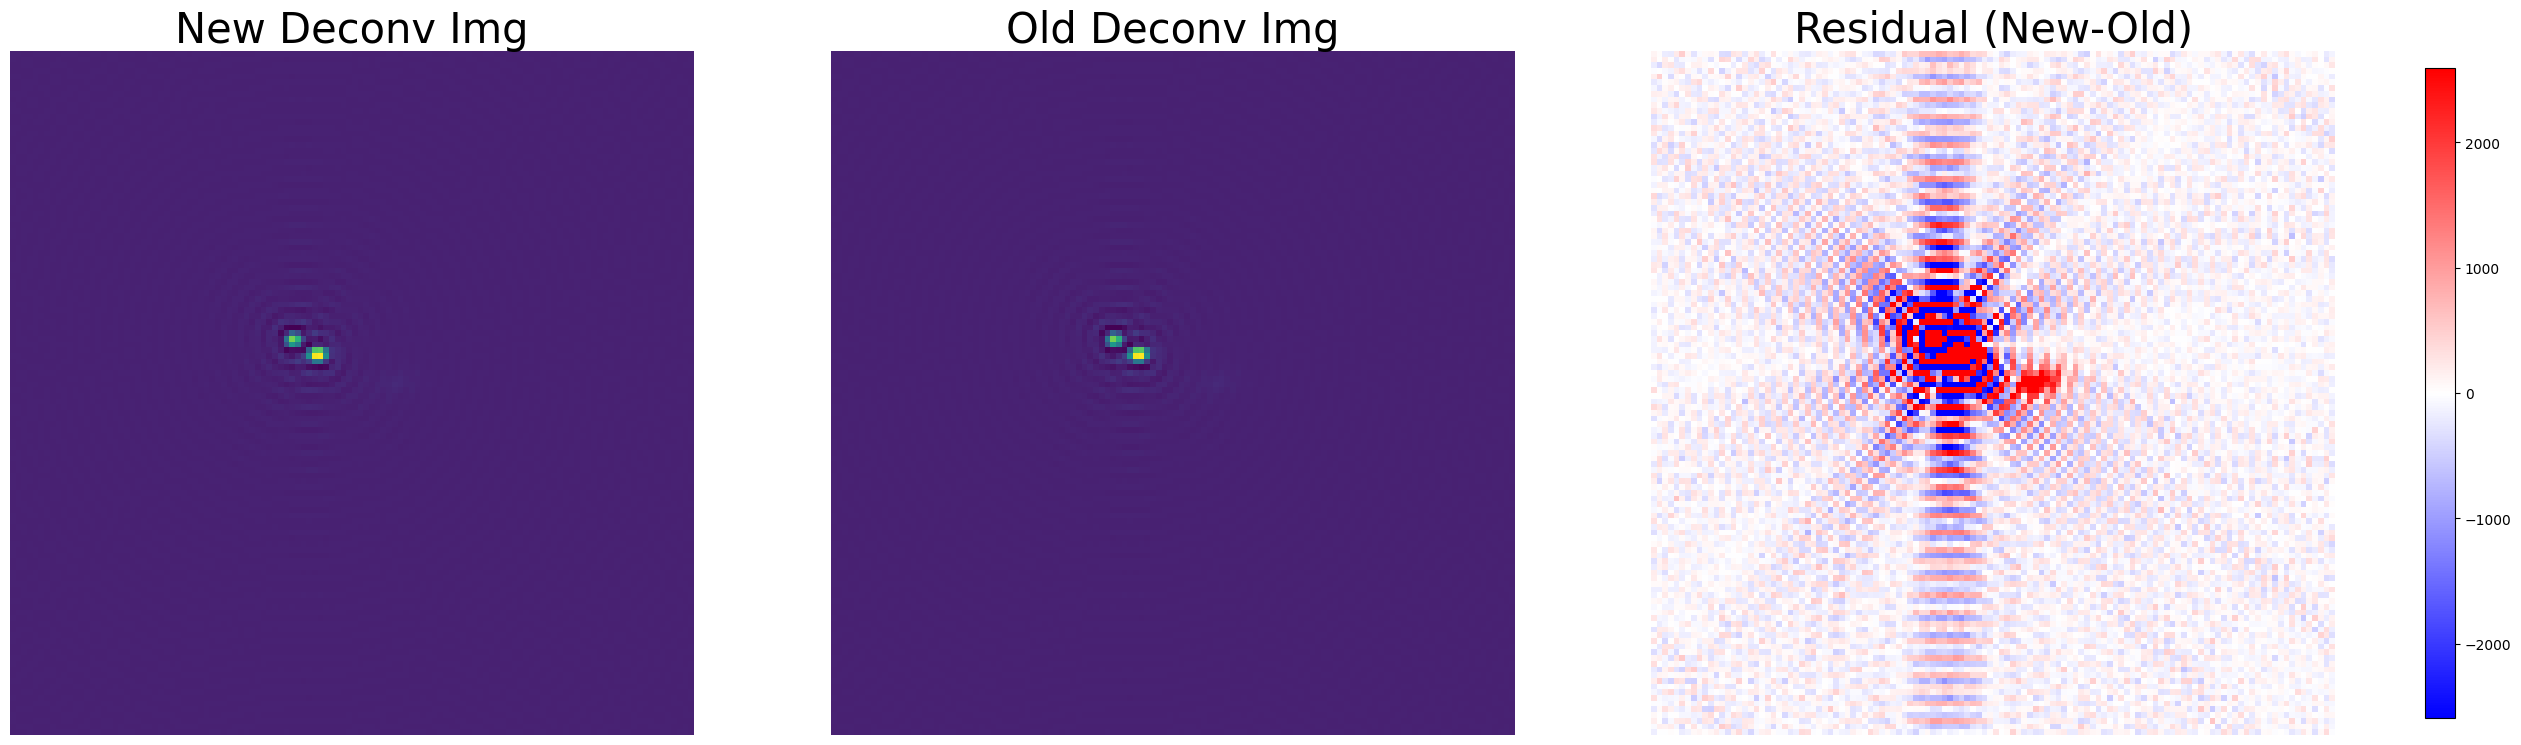

In [18]:
deconv_img, gal, psf_img = create_deconv_img(img=blend_images,
                                           psf=psf_images,
                                           sample_idx=9,
                                           gal_num_idx=0,
                                           filter_idx=0,
                                           eps=0.02)


deconv_img_old, gal, psf_img = create_deconv_img_old(img=blend_images,
                                           psf=psf_images,
                                           sample_idx=9,
                                           gal_num_idx=0,
                                           filter_idx=0,
                                           eps=0.02)


resid_deconv = deconv_img - deconv_img_old
vmax_resid = np.percentile((resid_deconv), (99))
vmin_resid = -vmax_resid


fig, axes = plt.subplots(1, 3, figsize=(30,26), sharex=True, sharey=True)
axes[0].imshow(deconv_img)
axes[0].axis('off')
axes[0].set_title('New Deconv Img', fontsize=30)
axes[1].imshow(deconv_img_old)
axes[1].axis('off')
axes[1].set_title('Old Deconv Img', fontsize=30)
im = axes[2].imshow(resid_deconv,vmin=vmin_resid, vmax=vmax_resid, cmap='bwr')
axes[2].axis('off')
axes[2].set_title('Residual (New-Old)', fontsize=30)

cax = plt.axes([0.93, 0.37, 0.01, 0.25])
fig.colorbar(im, cax=cax, ax=axes[2])
print("Sum of New Deconv image =", np.sum(deconv_img))
print("Sum of Old Deconv image =", np.sum(deconv_img_old))
print(np.sum(deconv_img)/np.sum(deconv_img_old))
# fig.tight_layout()
plt.show()

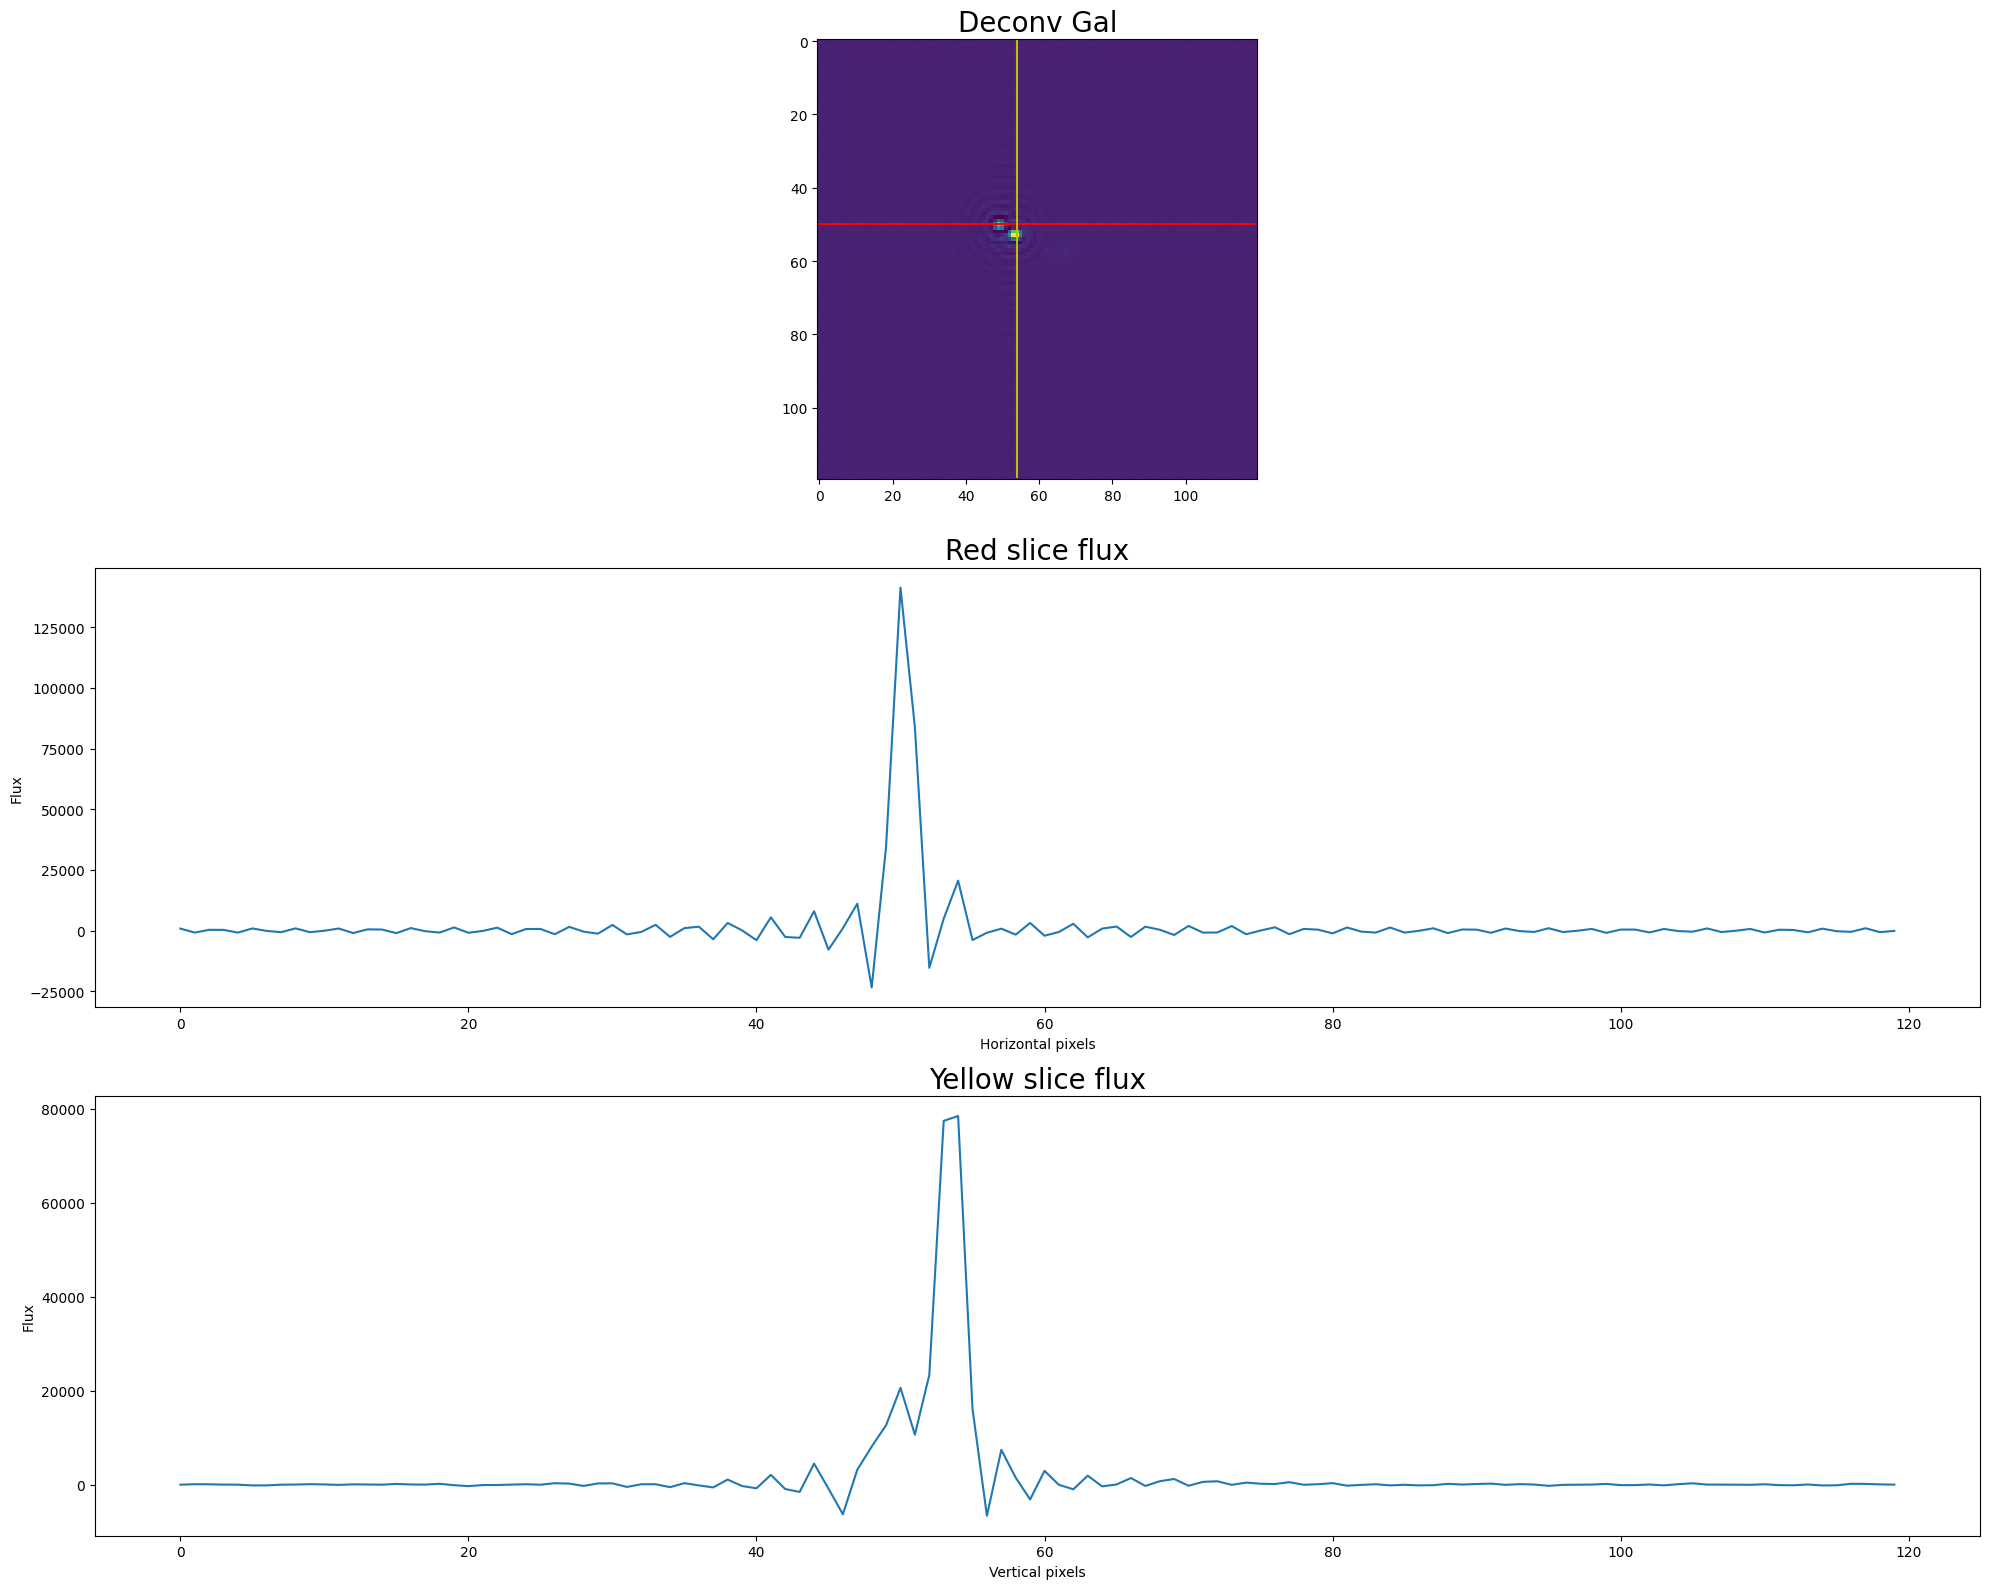

In [19]:
vis_ringing(img=deconv_img, x_idx=54, y_idx=50)

In [20]:
ind_max = np.unravel_index(np.argmax(deconv_img, axis=None), deconv_img.shape)
ind_min = np.unravel_index(np.argmin(deconv_img, axis=None), deconv_img.shape)

print("New max =", deconv_img[ind_max])
print("New min =", deconv_img[ind_min])
print("New max ind =", ind_max)
print("New min ind =", ind_min)

ind_max_old = np.unravel_index(np.argmax(deconv_img_old, axis=None), deconv_img_old.shape)
ind_min_old = np.unravel_index(np.argmin(deconv_img_old, axis=None), deconv_img_old.shape)

print("Old max =", deconv_img_old[ind_max_old])
print("Old min =", deconv_img_old[ind_min_old])
print("Old max ind =", ind_max_old)
print("Old min ind =", ind_min_old)

New max = 234414.20119542096
New min = -24221.069288858424
New max ind = (53, 54)
New min ind = (48, 49)
Old max = 1403.4949552367993
Old min = -145.01744539529474
Old max ind = (53, 54)
Old min ind = (48, 49)


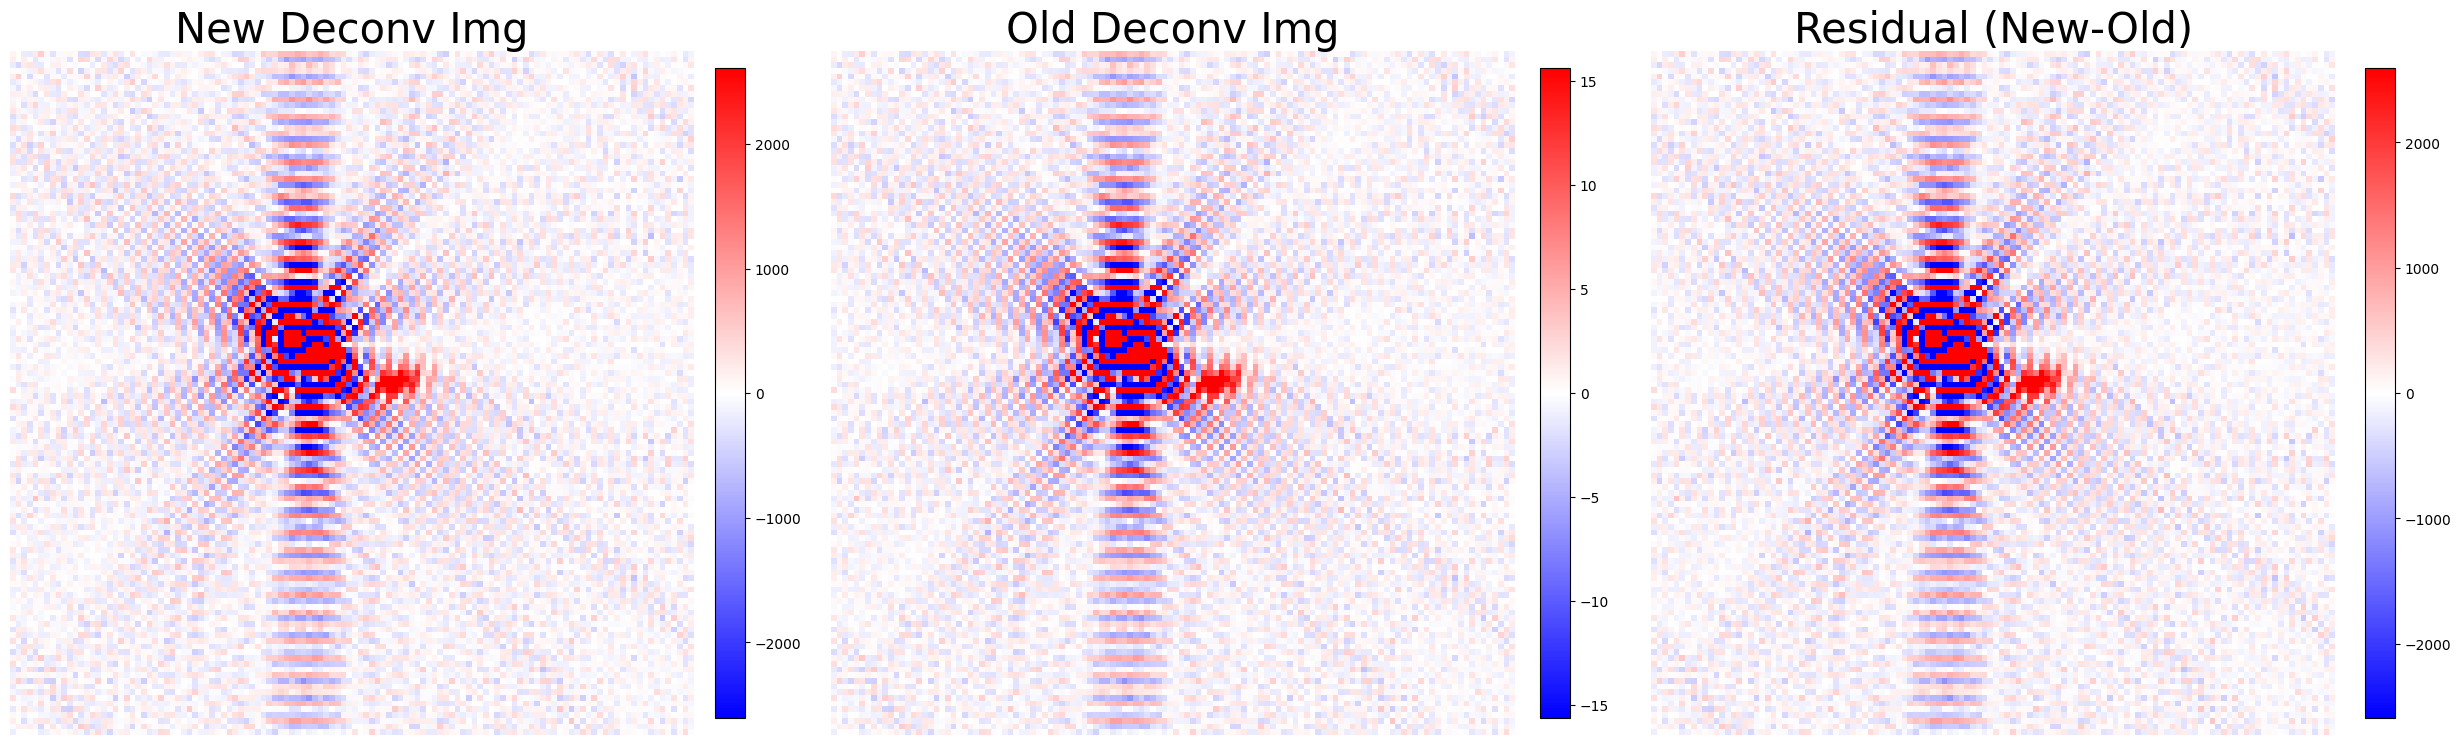

In [21]:
deconv_img, gal, psf_img = create_deconv_img(img=blend_images,
                                           psf=psf_images,
                                           sample_idx=9,
                                           gal_num_idx=0,
                                           filter_idx=0,
                                           eps=0.02)


deconv_img_old, gal, psf_img = create_deconv_img_old(img=blend_images,
                                           psf=psf_images,
                                           sample_idx=9,
                                           gal_num_idx=0,
                                           filter_idx=0,
                                           eps=0.02)
resid_deconv = deconv_img - deconv_img_old



vmax0 = np.percentile((deconv_img), (99))
vmin0 = -vmax0

fig, axes = plt.subplots(1, 3, figsize=(30,26), sharex=True, sharey=True)
im0 = axes[0].imshow(deconv_img, vmin=vmin0, vmax=vmax0, cmap='bwr')
cax = plt.axes([0.36, 0.37, 0.01, 0.25])
fig.colorbar(im0, cax=cax, ax=axes[0])
axes[0].axis('off')
axes[0].set_title('New Deconv Img', fontsize=30)



vmax1 = np.percentile((deconv_img_old), (99))
vmin1 = -vmax1
im1 = axes[1].imshow(deconv_img_old, vmin=vmin1, vmax=vmax1, cmap='bwr')
cax = plt.axes([0.635, 0.37, 0.01, 0.25])
fig.colorbar(im1, cax=cax, ax=axes[1])
axes[1].axis('off')
axes[1].set_title('Old Deconv Img', fontsize=30)




vmax_resid = np.percentile((resid_deconv), (99))
vmin_resid = -vmax_resid

im2 = axes[2].imshow(resid_deconv,vmin=vmin_resid, vmax=vmax_resid, cmap='bwr')
axes[2].axis('off')
axes[2].set_title('Residual (New-Old)', fontsize=30)
cax = plt.axes([0.91, 0.37, 0.01, 0.25])
fig.colorbar(im2, cax=cax, ax=axes[2])

plt.show()

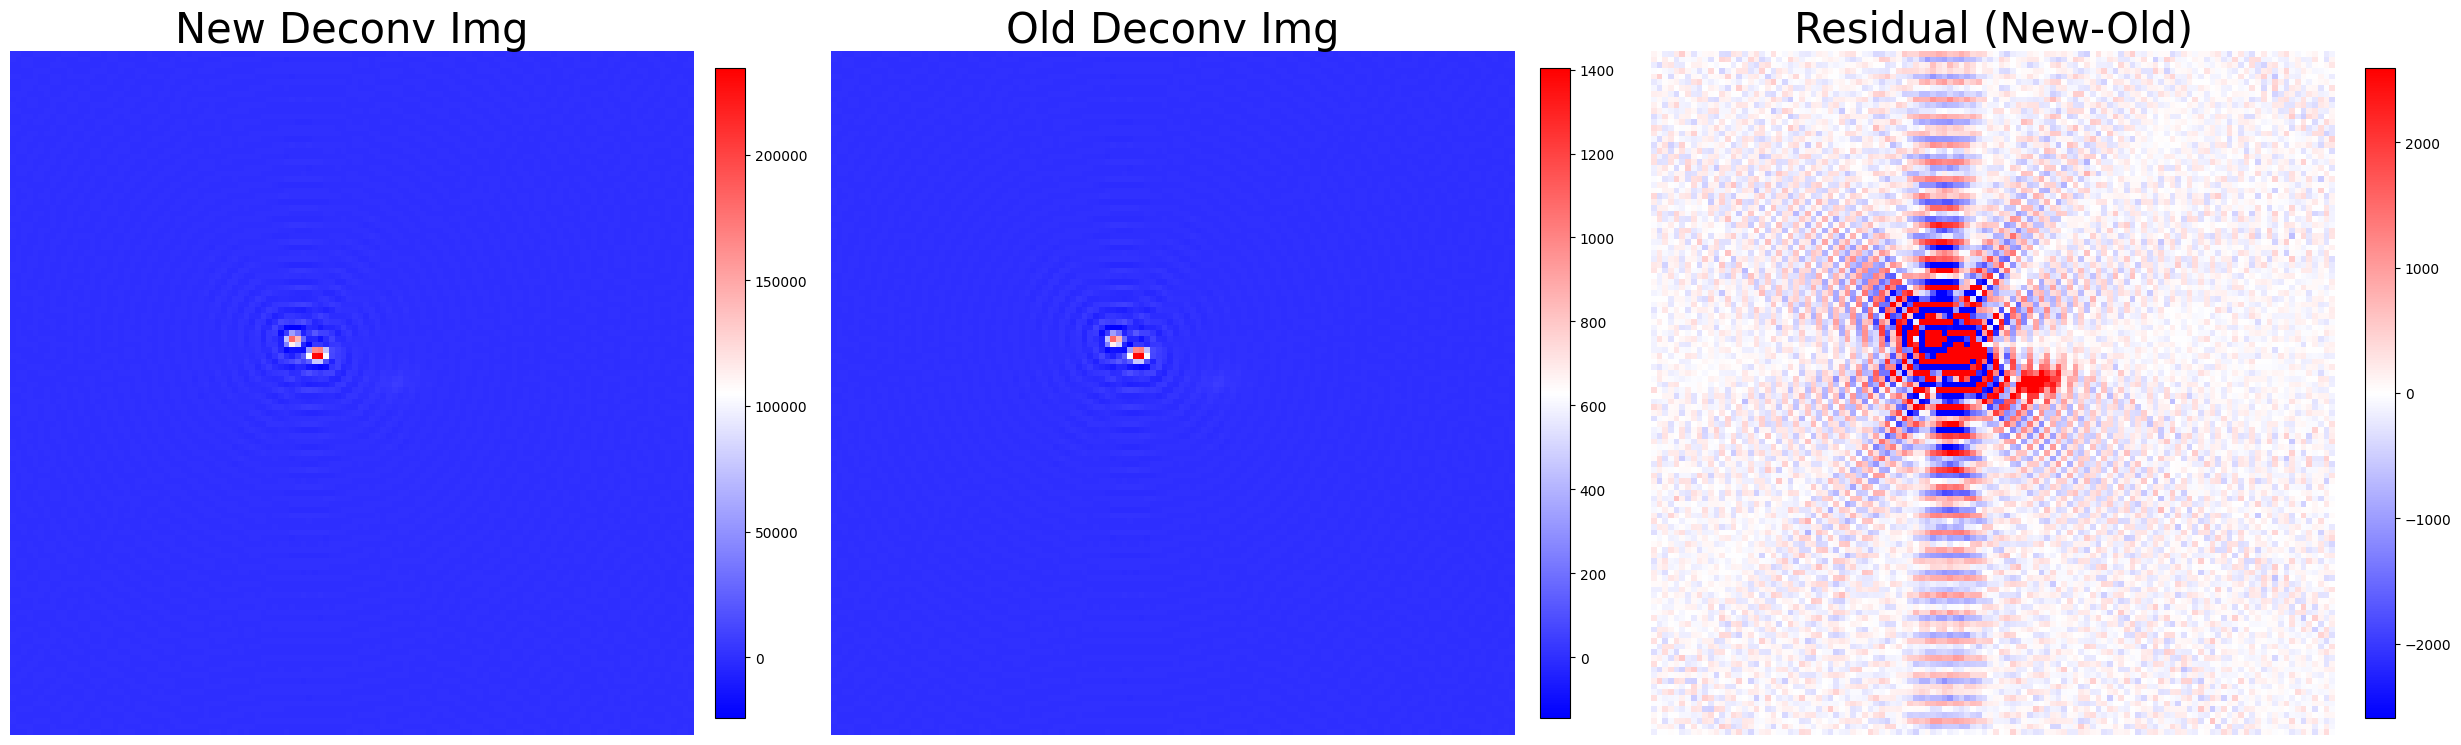

In [22]:
deconv_img, gal, psf_img = create_deconv_img(img=blend_images,
                                           psf=psf_images,
                                           sample_idx=9,
                                           gal_num_idx=0,
                                           filter_idx=0,
                                           eps=0.02)


deconv_img_old, gal, psf_img = create_deconv_img_old(img=blend_images,
                                           psf=psf_images,
                                           sample_idx=9,
                                           gal_num_idx=0,
                                           filter_idx=0,
                                           eps=0.02)


resid_deconv = deconv_img - deconv_img_old
vmax_resid = np.percentile((resid_deconv), (99))
vmin_resid = -vmax_resid


fig, axes = plt.subplots(1, 3, figsize=(30,26), sharex=True, sharey=True)
im0 = axes[0].imshow(deconv_img, cmap='bwr')
cax = plt.axes([0.36, 0.37, 0.01, 0.25])
fig.colorbar(im0, cax=cax, ax=axes[0])
axes[0].axis('off')
axes[0].set_title('New Deconv Img', fontsize=30)


im1 = axes[1].imshow(deconv_img_old, cmap='bwr')
cax = plt.axes([0.635, 0.37, 0.01, 0.25])
fig.colorbar(im1, cax=cax, ax=axes[1])
axes[1].axis('off')
axes[1].set_title('Old Deconv Img', fontsize=30)

im2 = axes[2].imshow(resid_deconv,vmin=vmin_resid, vmax=vmax_resid, cmap='bwr')
axes[2].axis('off')
axes[2].set_title('Residual (New-Old)', fontsize=30)
cax = plt.axes([0.91, 0.37, 0.01, 0.25])
fig.colorbar(im2, cax=cax, ax=axes[2])

plt.show()

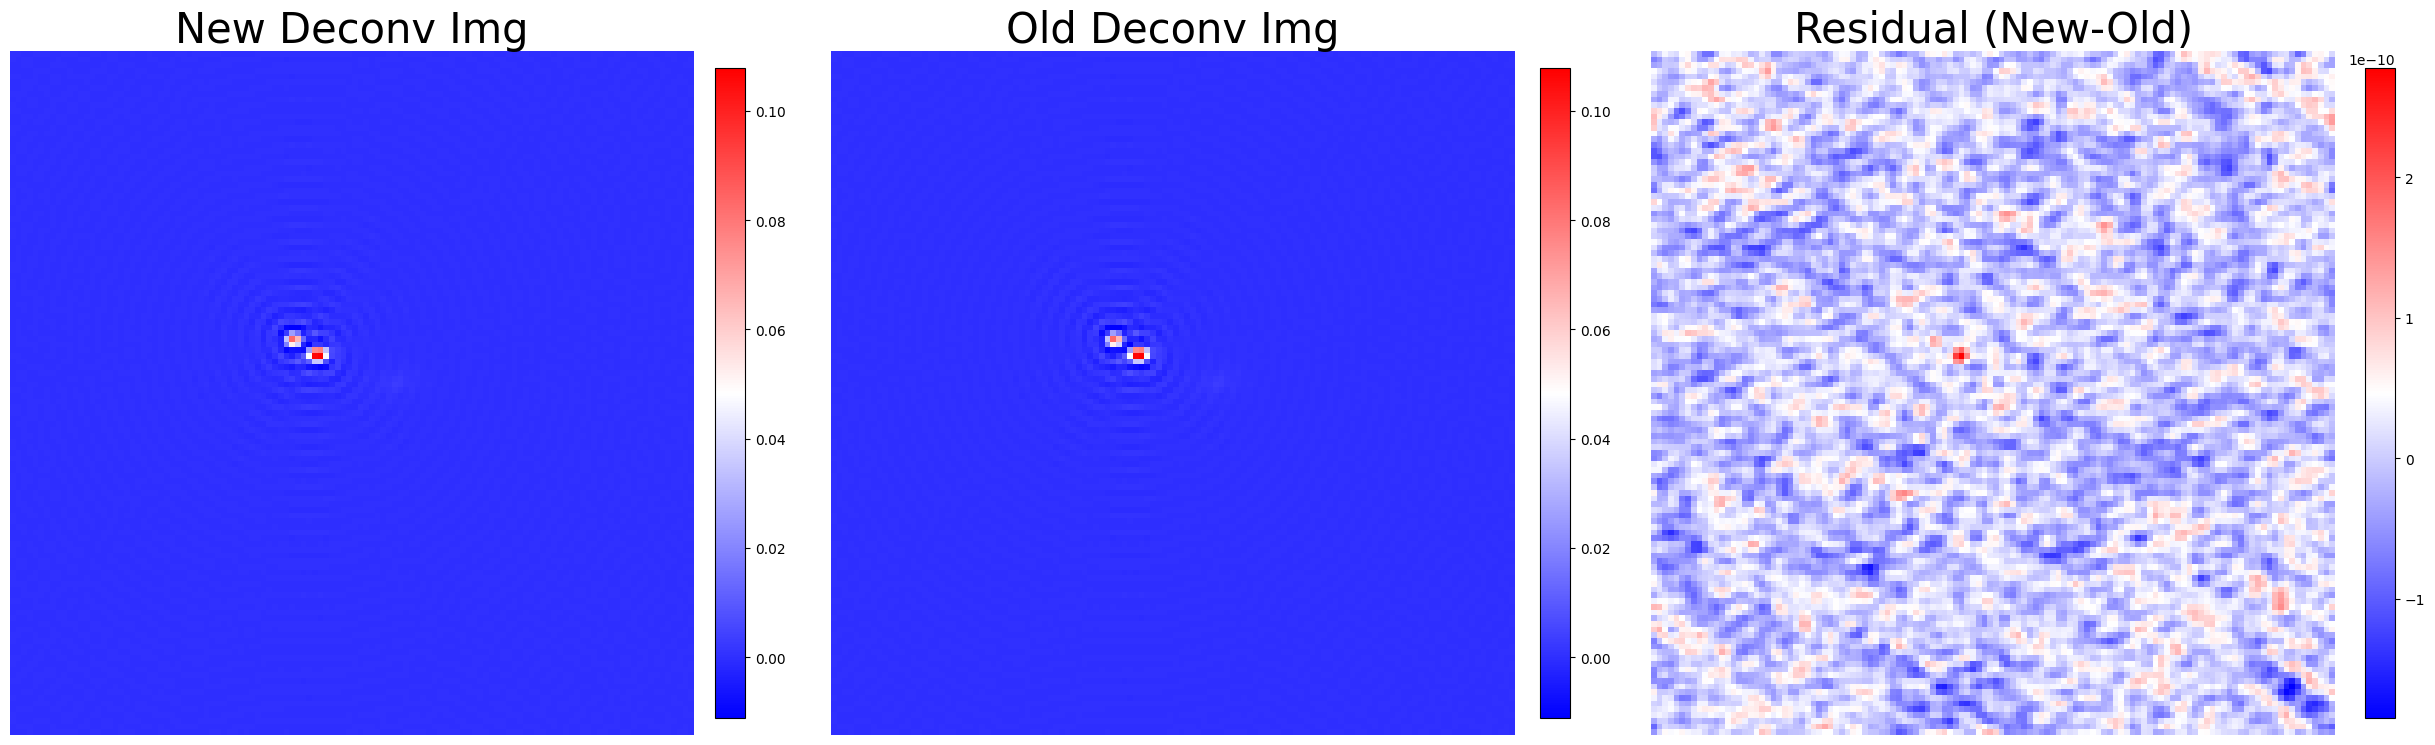

In [23]:
deconv_img, gal, psf_img = create_deconv_img(img=blend_images,
                                           psf=psf_images,
                                           sample_idx=9,
                                           gal_num_idx=0,
                                           filter_idx=0,
                                           eps=0.02)
# Normalize the flux to be between [-1,1]
deconv_img = deconv_img/np.sum(deconv_img)


deconv_img_old, gal, psf_img = create_deconv_img_old(img=blend_images,
                                           psf=psf_images,
                                           sample_idx=9,
                                           gal_num_idx=0,
                                           filter_idx=0,
                                           eps=0.02)
# Normalize the flux to be between [-1,1]
deconv_img_old = deconv_img_old/np.sum(deconv_img_old)

# Calculate residual of the two images
resid_deconv = (deconv_img) - (deconv_img_old)
vmax_resid = np.percentile((resid_deconv), (99))
vmin_resid = -vmax_resid


fig, axes = plt.subplots(1, 3, figsize=(30,26), sharex=True, sharey=True)
im0 = axes[0].imshow(deconv_img, cmap='bwr')
cax = plt.axes([0.36, 0.37, 0.01, 0.25])
fig.colorbar(im0, cax=cax, ax=axes[0])
axes[0].axis('off')
axes[0].set_title('New Deconv Img', fontsize=30)


im1 = axes[1].imshow(deconv_img_old, cmap='bwr')
cax = plt.axes([0.635, 0.37, 0.01, 0.25])
fig.colorbar(im1, cax=cax, ax=axes[1])
axes[1].axis('off')
axes[1].set_title('Old Deconv Img', fontsize=30)

im2 = axes[2].imshow(resid_deconv, cmap='bwr')
axes[2].axis('off')
axes[2].set_title('Residual (New-Old)', fontsize=30)
cax = plt.axes([0.91, 0.37, 0.01, 0.25])
fig.colorbar(im2, cax=cax, ax=axes[2])

plt.show()